In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import savgol_filter, find_peaks
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [3]:
def gompertz_growth_rate(t, A, mu, l):
    gr = mu * np.exp(np.exp(1) * mu * (l - t) / A - np.exp(np.exp(1) * mu * (l - t) / A + 1) + 2)
    return gr

In [4]:
def tm_gomp(A, mu, l):
    return A / (mu * np.e) + l

In [5]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
positions = pd.read_excel('../Positions.xlsx')

df = pd.read_excel('../data_processed.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')

pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Group by 'Date', 'Machine', and 'Pad' and calculate mean, std, and count of 'area_max_um'
agg_colony_area_df = df.groupby(['Date', 'Machine', 'Pad'])['area_max_um'].agg(['mean', 'std', 'count']).reset_index()

# Rename the columns for clarity
agg_colony_area_df.rename(columns={'mean': 'mean_colony_area', 'std': 'std_colony_area', 'count': 'num_colonies'}, inplace=True)

# Merge the grouped data from 'positions' and the aggregated colony area data from 'df'
df_N_A = pd.merge(pos_grouped, agg_colony_area_df, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A.head()

Date      Machine  Pad  total_colonies  mean_colony_area  \
0 2023-11-15     Ti scope    1            19.0     127494.473143   
1 2023-11-15     Ti scope    2            23.0      46725.168600   
2 2023-11-15  Tweez scope    1             3.0     768482.640000   
3 2023-11-15  Tweez scope    2             1.0     476031.532500   
4 2023-11-17     Ti scope    1             6.0     366810.583800   

   std_colony_area  num_colonies  
0     21643.298316             7  
1     15593.763903             2  
2     99168.204670             2  
3              NaN             1  
4     47734.937249             6

#### A*N vs N

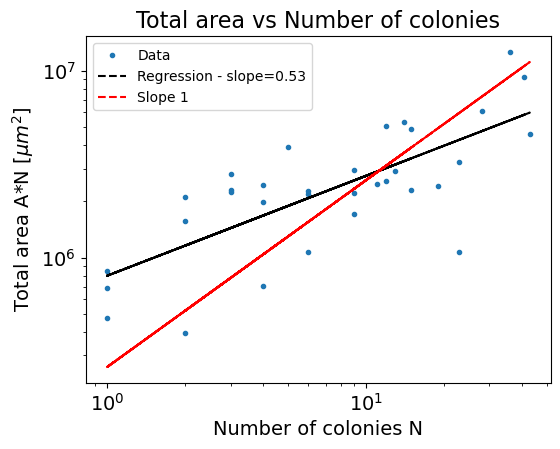

In [56]:
AN = df_N_A['total_colonies'] * df_N_A['mean_colony_area']

# linear regression in log-log space
log_N = np.log10(df_N_A['total_colonies'])
log_AN = np.log10(AN)

# fit the regression model (linear fit in log-log space)
slope, intercept = np.polyfit(log_N, log_AN, 1)
# create the regression line in log-log space
regression_line = 10**(slope * log_N + intercept)

# Calculate the scaling factor to align the slope 1 line with the data
scaling_factor = (df_N_A['total_colonies'] * df_N_A['mean_colony_area']).mean() / df_N_A['total_colonies'].mean()
# Plotting a slope 1 line for reference in log-log space, scaled to match the data
slope_1_line = scaling_factor * df_N_A['total_colonies']  # Slope 1 line

plt.figure(figsize=(6,4.5))
plt.yscale('log')
plt.xscale('log')

plt.plot(df_N_A['total_colonies'], AN, '.', label='Data')
plt.plot(df_N_A['total_colonies'], regression_line, '--', label=f'Regression - slope={slope:.2f}', color='black')
plt.plot(df_N_A['total_colonies'], slope_1_line, '--', label='Slope 1', color='red')

plt.ylabel('Total area A*N [$\mu m^2$]', fontsize=14)
plt.xlabel('Number of colonies N', fontsize=14)
plt.title('Total area vs Number of colonies', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust the tick size here

plt.legend()

#plt.savefig('AN_N.png', dpi=300)
plt.show()

#### Gompertz params vs N

In [13]:
df_gomp = df.groupby(['Date','Machine','Pad'])[['A_gomp_um','mu_gomp_um','l_gomp_um']].agg(['mean','std']).reset_index()
df_gomp.columns = ['_'.join(filter(None, col)).strip('_') for col in df_gomp.columns.values]
df_gomp.head()

Date      Machine  Pad  A_gomp_um_mean  A_gomp_um_std  \
0 2023-11-15     Ti scope    1   124844.505297   21029.802963   
1 2023-11-15     Ti scope    2    44951.936568   14489.775612   
2 2023-11-15  Tweez scope    1   761776.515325   97483.118497   
3 2023-11-15  Tweez scope    2   469881.069646            NaN   
4 2023-11-17     Ti scope    1   362891.221616   47016.657638   

   mu_gomp_um_mean  mu_gomp_um_std  l_gomp_um_mean  l_gomp_um_std  
0       414.191407       76.516590      347.800191      14.380969  
1       115.569528       45.912740      390.868408      13.372949  
2      1649.906803       39.333283      438.492732      32.238057  
3      1050.361432             NaN      423.652960            NaN  
4       801.770163      124.341047      373.917657      12.847217

In [14]:
# merge total colonies and average area with gompertz params dataframes
df_N_A_gomp = pd.merge(df_gomp, df_N_A, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A_gomp.head()

Date      Machine  Pad  A_gomp_um_mean  A_gomp_um_std  \
0 2023-11-15     Ti scope    1   124844.505297   21029.802963   
1 2023-11-15     Ti scope    2    44951.936568   14489.775612   
2 2023-11-15  Tweez scope    1   761776.515325   97483.118497   
3 2023-11-15  Tweez scope    2   469881.069646            NaN   
4 2023-11-17     Ti scope    1   362891.221616   47016.657638   

   mu_gomp_um_mean  mu_gomp_um_std  l_gomp_um_mean  l_gomp_um_std  \
0       414.191407       76.516590      347.800191      14.380969   
1       115.569528       45.912740      390.868408      13.372949   
2      1649.906803       39.333283      438.492732      32.238057   
3      1050.361432             NaN      423.652960            NaN   
4       801.770163      124.341047      373.917657      12.847217   

   total_colonies  mean_colony_area  std_colony_area  num_colonies  
0            19.0     127494.473143     21643.298316             7  
1            23.0      46725.168600     15593.763903             2  
2             3.0     768482.640000     99168.204670             2  
3             1.0     476031.532500              NaN             1  
4             6.0     366810.583800     47734.937249             6

In [15]:
pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Merge the grouped data back into the original DataFrame
df_N_A_gomp_all_pos = df.merge(pos_grouped, on=['Date', 'Machine', 'Pad'], how='left')

# Display the updated DataFrame
df_N_A_gomp_all_pos.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20&pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20&pLPT41        -    1   
2 2023-11-15  Ti scope         3  MC4100  pLPT20&pLPT41        -    1   
3 2023-11-15  Ti scope         6  MC4100  pLPT20&pLPT41        -    1   
4 2023-11-15  Ti scope         7  MC4100  pLPT20&pLPT41        -    1   

  Dilution   t_incub      t_im  ...      r0_um      A_gomp_um  mu_gomp_um  \
0  10^(-5)  09:25:00  14:41:00  ...  25.726989  103786.407908  343.235436   
1  10^(-5)  09:25:00  14:41:00  ...  37.567485  148648.903676  486.687306   
2  10^(-5)  09:25:00  14:41:00  ...  50.002925  138470.390891  463.743309   
3  10^(-5)  09:25:00  14:41:00  ...  23.368757  100919.606151  319.217899   
4  10^(-5)  09:25:00  14:41:00  ...  35.216651  131433.344500  451.356518   

    l_gomp_um  gomp_growth_stops_10       tm_um      A_gomp_px  mu_gomp_px  \
0  366.413055                   982  477.651236   79860.270682  264.108533   
1  354.501107                  1015  466.862525  114380.499530  374.490570   
2  343.273546                   984  453.119680  106548.466672  356.835713   
3  320.089585                   955  436.393365   77654.359914  245.627809   
4  345.419708                   968  452.544838  101133.690444  347.304220   

    l_gomp_px  total_colonies  
0  366.413060            19.0  
1  354.501291            19.0  
2  343.273661            19.0  
3  320.089585            19.0  
4  345.419723            19.0  

[5 rows x 47 columns]

#### A vs area_max_um

Text(0, 0.5, 'A Gomp')

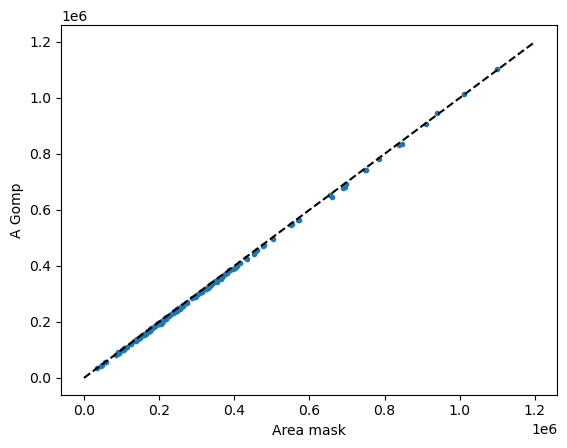

In [16]:
plt.plot(df['area_max_um'],df['A_gomp_um'],'.')
plt.plot(np.arange(0,1.2e6), np.arange(0,1.2e6), 'k--')
plt.xlabel('Area mask')
plt.ylabel('A Gomp')

#### A vs N

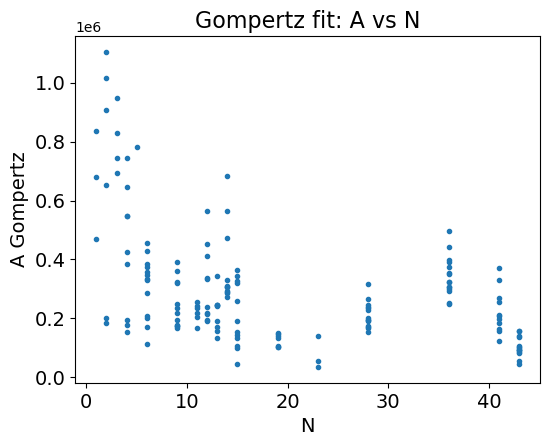

In [21]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['A_gomp_um'], '.')
plt.ylabel('A Gompertz', fontsize=14)
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: A vs N', fontsize=16)
#plt.savefig('AGomp_N.png', dpi=300)
plt.show()


#### $\mu_m$ vs N

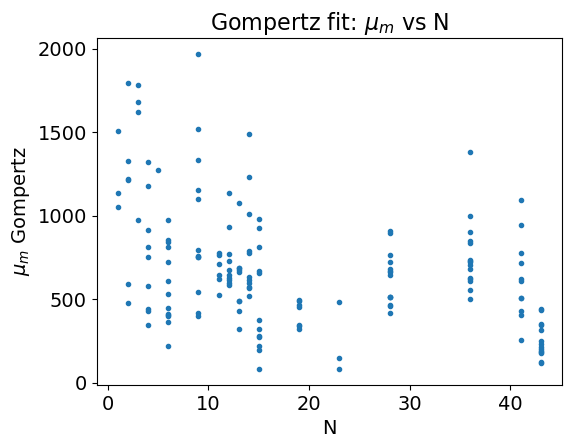

In [22]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['mu_gomp_um'], '.')
plt.ylabel('$\\mu_m$ Gompertz', fontsize=14)
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: $\mu_m$ vs N', fontsize=16)
#plt.savefig('muGomp_N.png', dpi=300)
plt.show()

#### $\lambda$ vs N

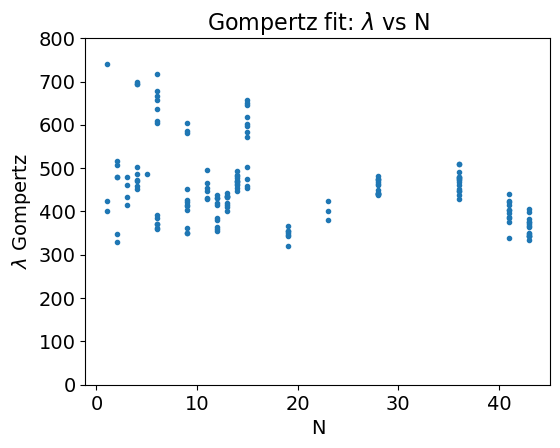

In [23]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['l_gomp_um'], '.')
plt.ylabel('$\\lambda$ Gompertz', fontsize=14)
plt.ylim([0, 800])
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: $\lambda$ vs N', fontsize=16)
#plt.savefig('lGomp_N.png', dpi=300)
plt.show()


#### $r_0$ vs N

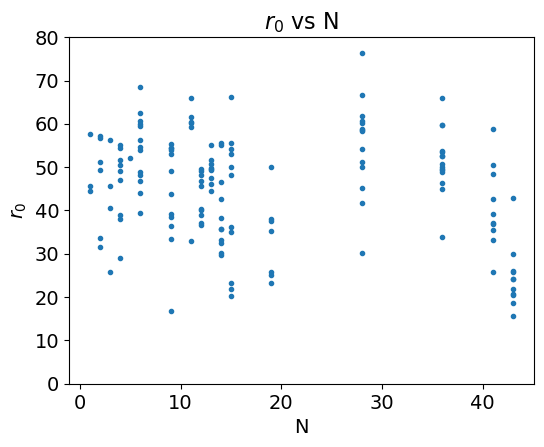

In [31]:
df_N_A_gomp_all_pos_r0 = df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 1]

plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos_r0['total_colonies'], df_N_A_gomp_all_pos_r0['r0_um'], '.')
plt.ylabel('$r_0$', fontsize=14)
plt.ylim([0, 80])
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$r_0$ vs N', fontsize=16)
#plt.savefig('r0_N.png', dpi=300)
plt.show()


#### A vs $r_0$

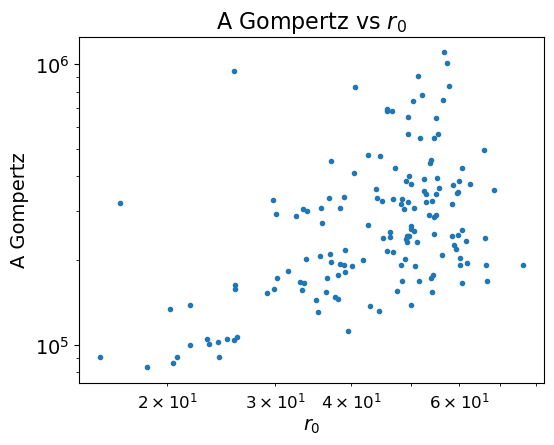

In [33]:
plt.figure(figsize=(6,4.5))

plt.yscale('log')
plt.xscale('log')

plt.plot(df_N_A_gomp_all_pos_r0['r0_um'], df_N_A_gomp_all_pos_r0['A_gomp_um'], '.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel('A Gompertz', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.title('A Gompertz vs $r_0$', fontsize=16)
#plt.savefig('AGomp_r0.png', dpi=300)
plt.show()

#### Time stops growth

0


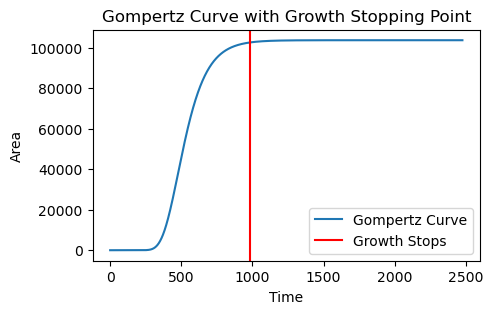

The colony stops growing around time: 982
1


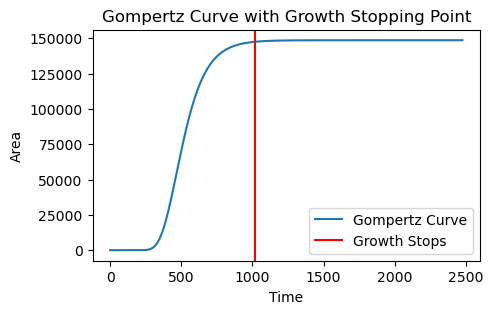

The colony stops growing around time: 1015
2


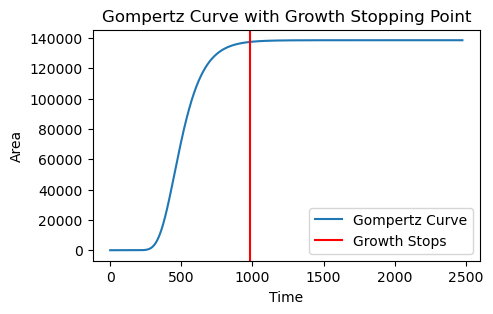

The colony stops growing around time: 984
3


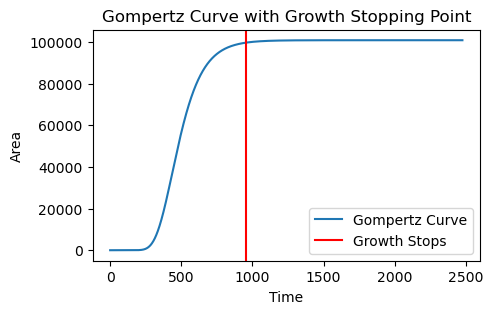

The colony stops growing around time: 955
4


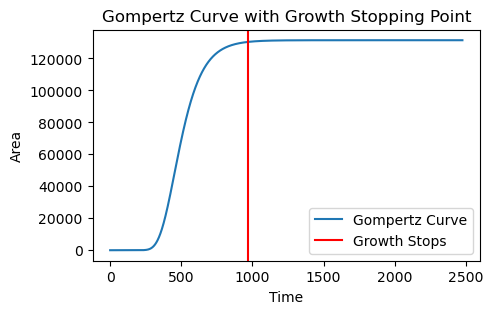

The colony stops growing around time: 968
5


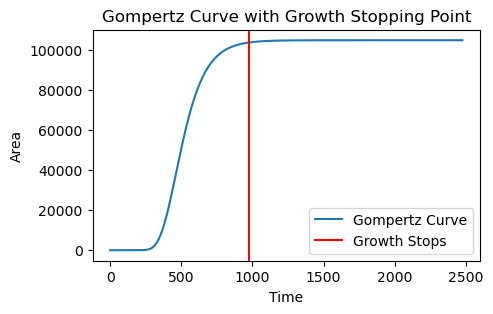

The colony stops growing around time: 976
6


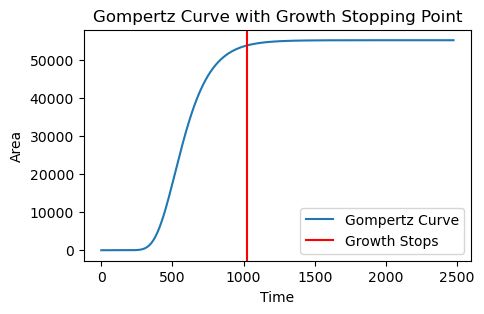

The colony stops growing around time: 1022
7


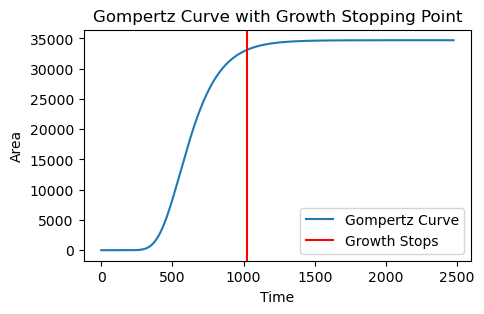

The colony stops growing around time: 1026
8


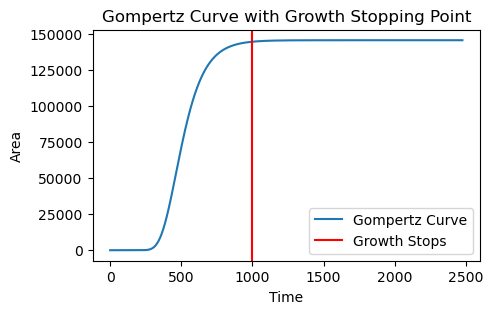

The colony stops growing around time: 995
9


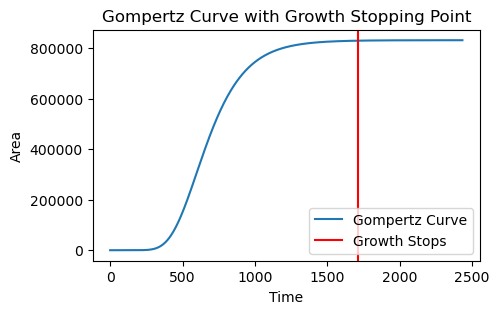

The colony stops growing around time: 1713
10


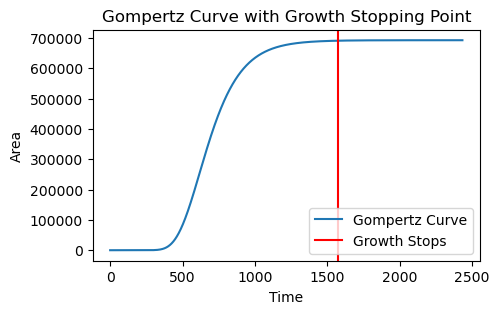

The colony stops growing around time: 1575
11


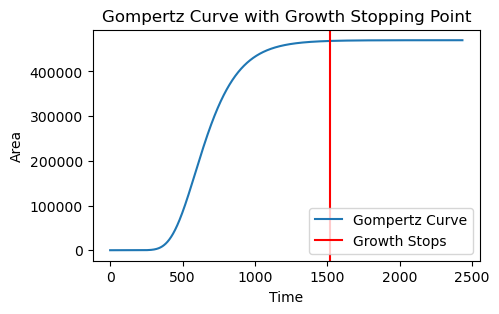

The colony stops growing around time: 1519
12


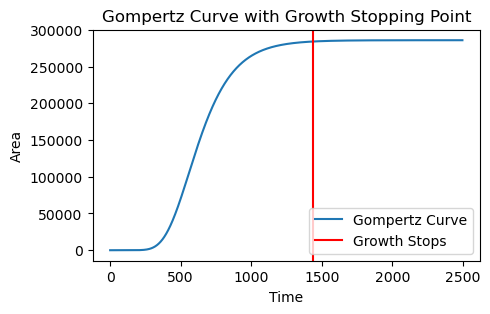

The colony stops growing around time: 1440
13


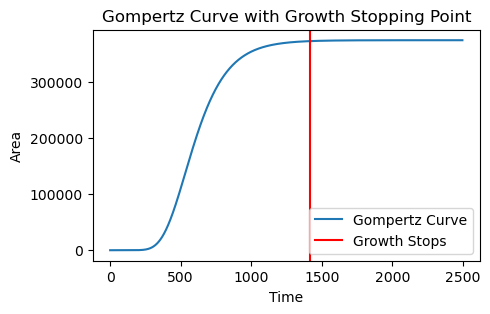

The colony stops growing around time: 1415
14


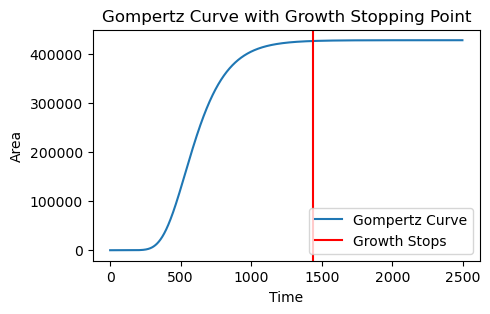

The colony stops growing around time: 1434
15


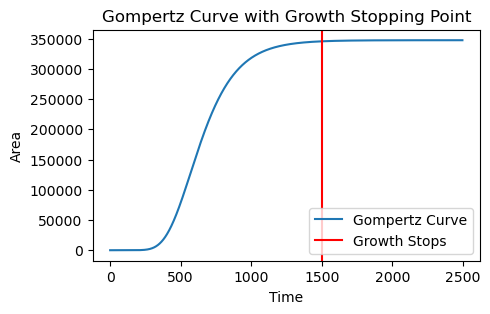

The colony stops growing around time: 1504
16


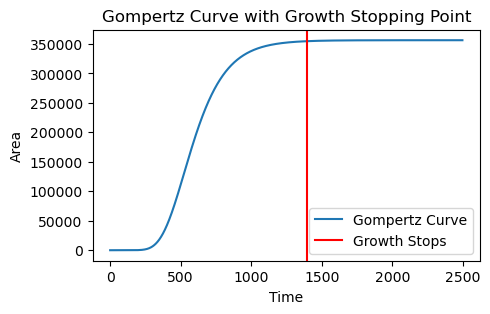

The colony stops growing around time: 1397
17


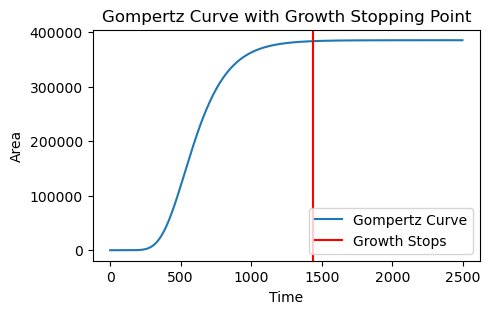

The colony stops growing around time: 1440
18


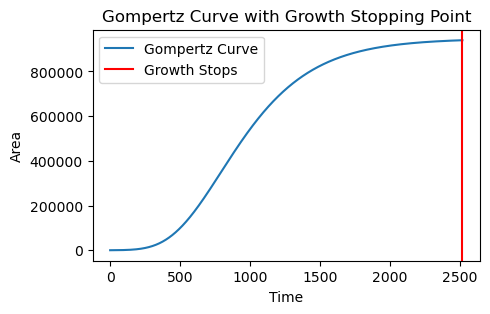

The colony stops growing around time: 2519
19


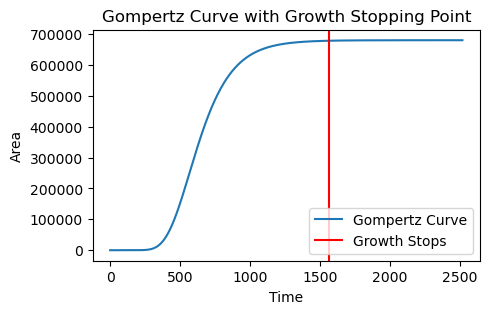

The colony stops growing around time: 1567
20


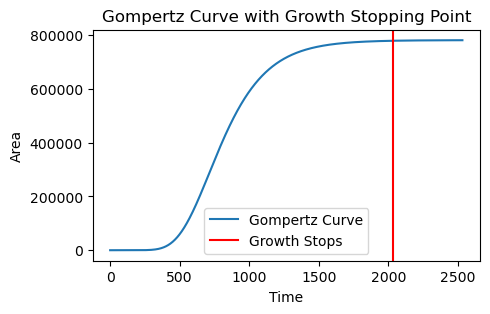

The colony stops growing around time: 2033
21


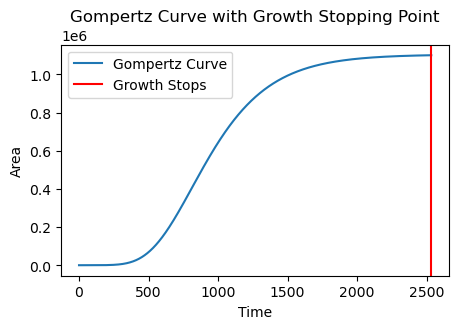

The colony stops growing around time: 2533
22


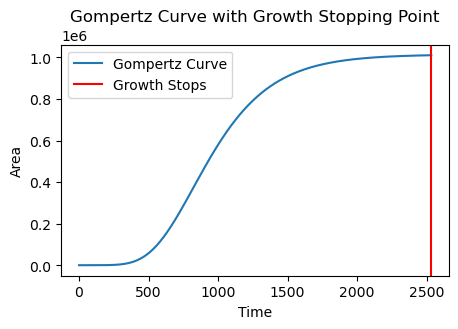

The colony stops growing around time: 2533
23


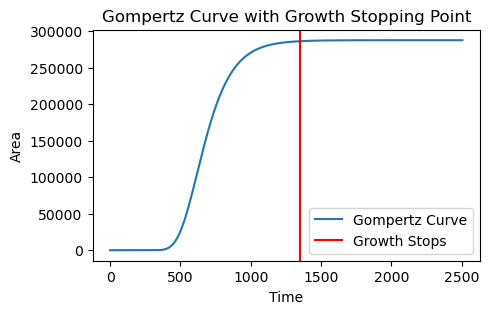

The colony stops growing around time: 1348
24


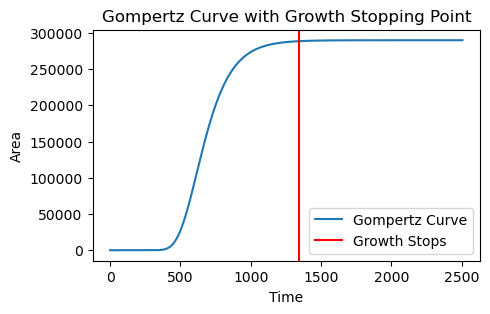

The colony stops growing around time: 1340
25


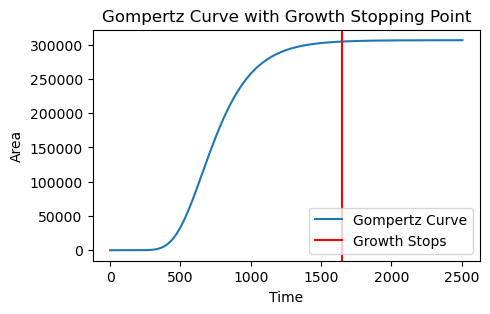

The colony stops growing around time: 1648
26


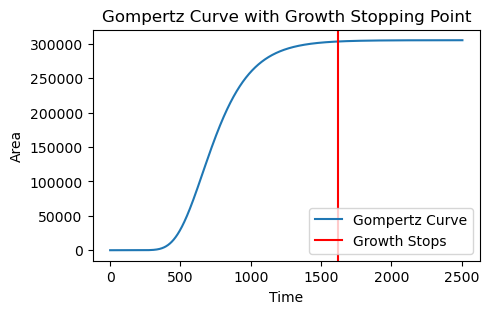

The colony stops growing around time: 1618
27


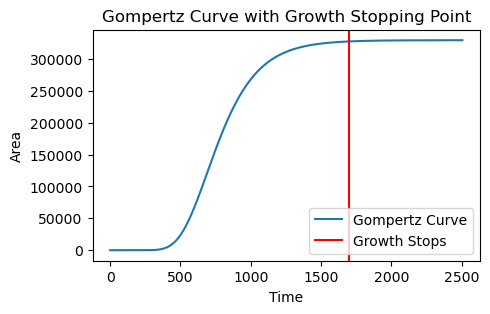

The colony stops growing around time: 1696
28


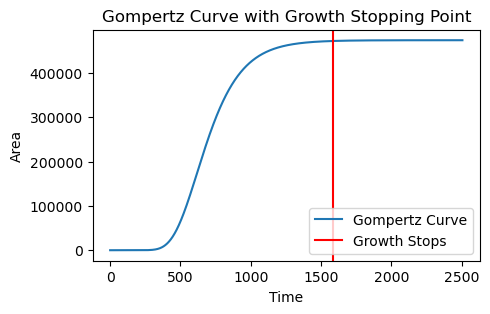

The colony stops growing around time: 1586
29


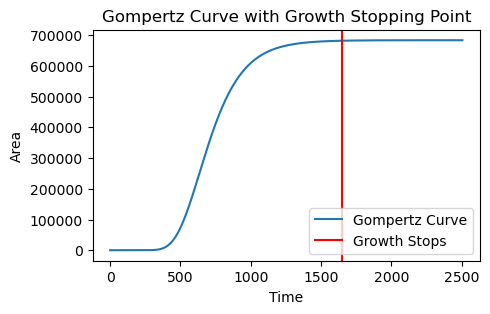

The colony stops growing around time: 1648
30


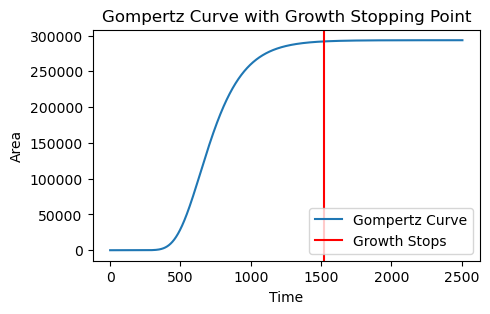

The colony stops growing around time: 1518
31


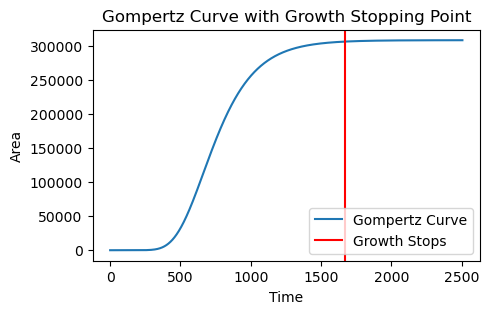

The colony stops growing around time: 1673
32


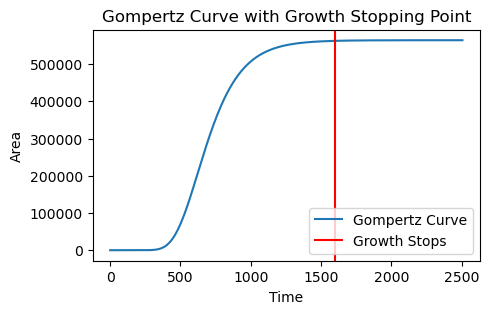

The colony stops growing around time: 1603
33


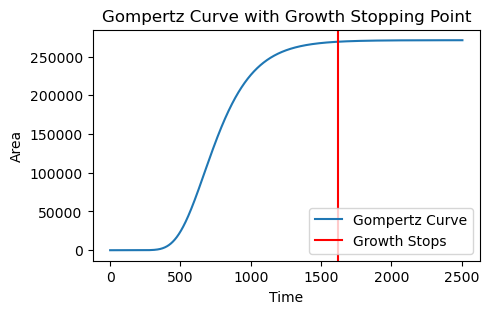

The colony stops growing around time: 1624
34


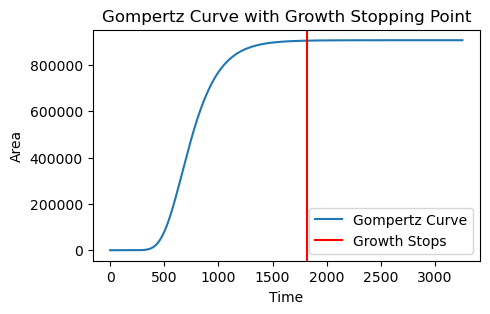

The colony stops growing around time: 1815
35


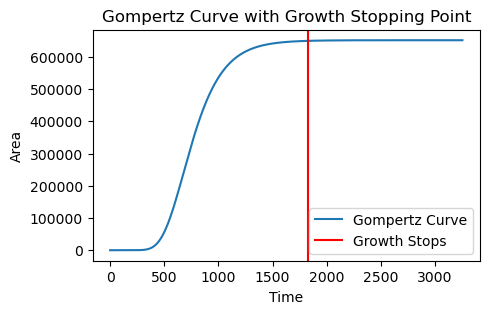

The colony stops growing around time: 1824
36


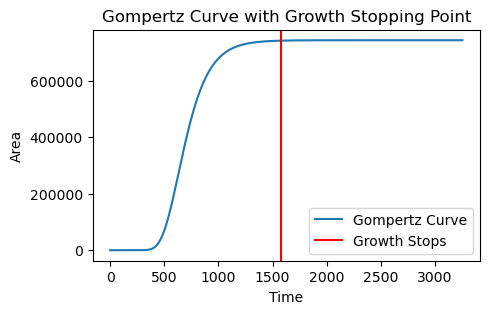

The colony stops growing around time: 1581
37


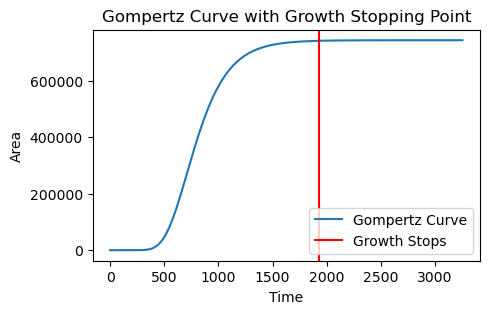

The colony stops growing around time: 1929
38


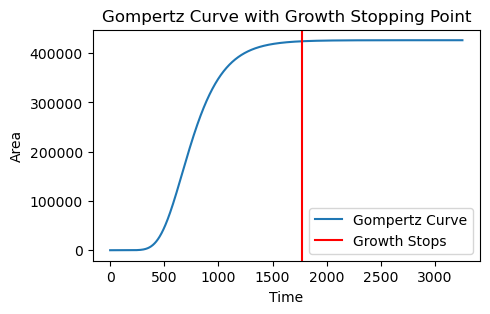

The colony stops growing around time: 1773
39


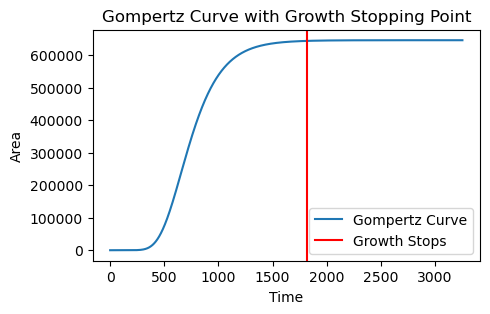

The colony stops growing around time: 1821
40


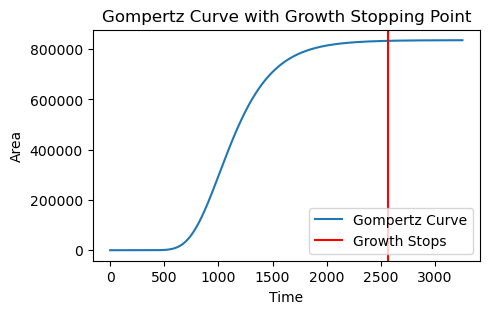

The colony stops growing around time: 2561
41


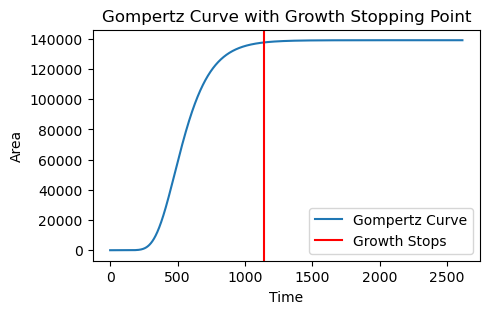

The colony stops growing around time: 1143
42


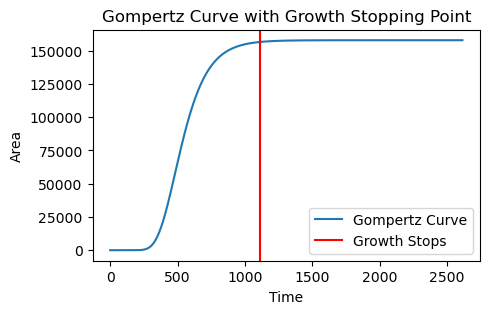

The colony stops growing around time: 1111
43


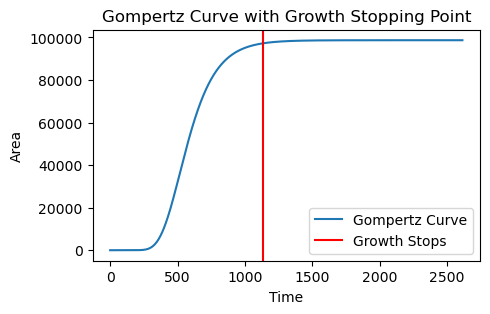

The colony stops growing around time: 1133
44


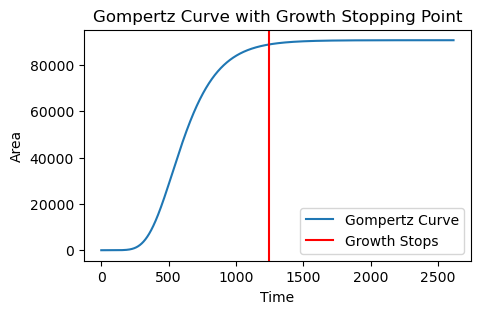

The colony stops growing around time: 1243
45


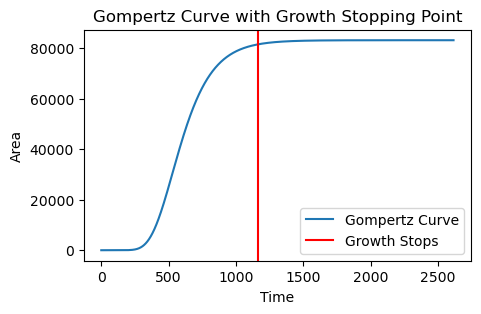

The colony stops growing around time: 1164
46


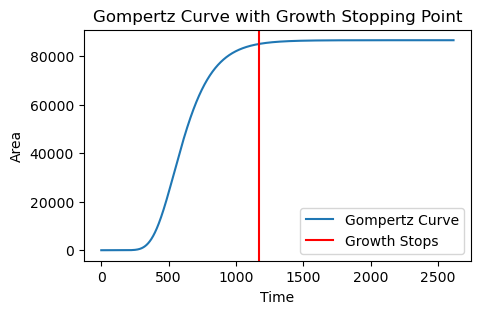

The colony stops growing around time: 1167
47


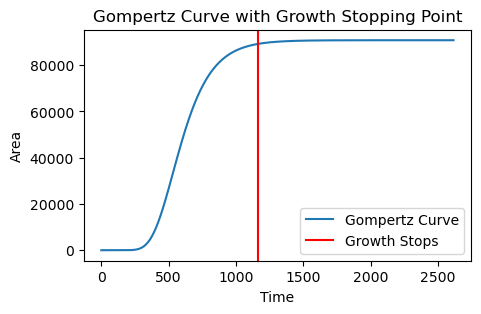

The colony stops growing around time: 1165
48


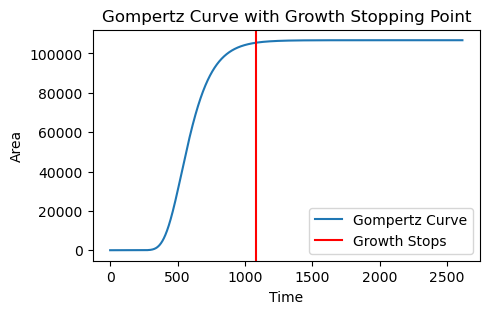

The colony stops growing around time: 1084
49


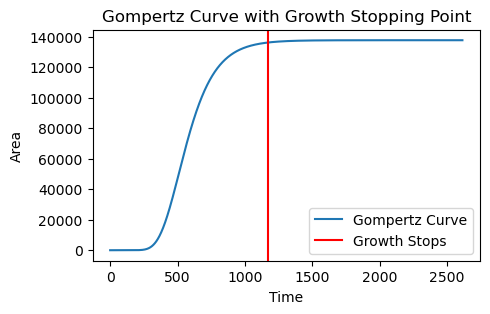

The colony stops growing around time: 1175
50


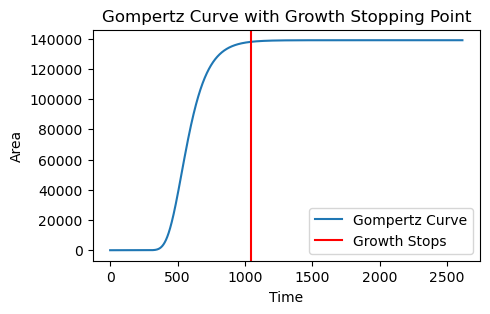

The colony stops growing around time: 1046
51


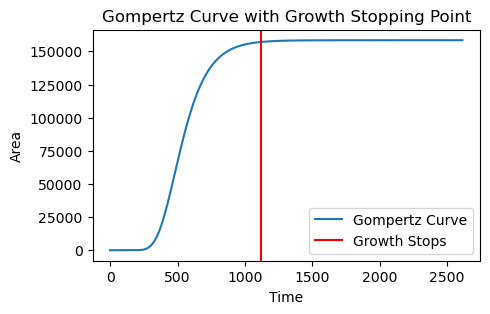

The colony stops growing around time: 1118
52


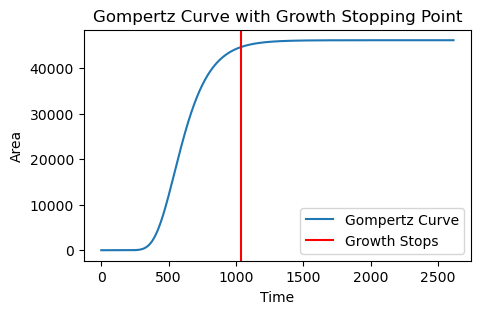

The colony stops growing around time: 1040
53


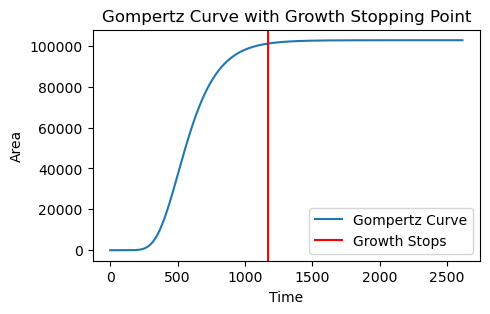

The colony stops growing around time: 1173
54


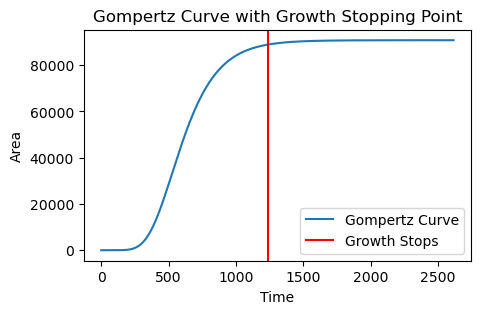

The colony stops growing around time: 1240
55


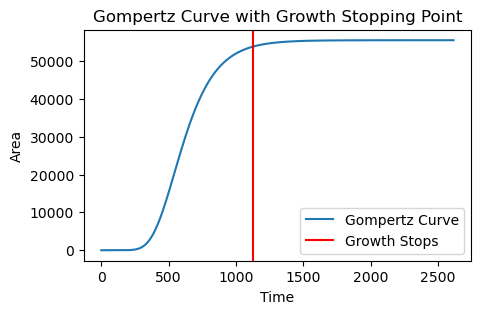

The colony stops growing around time: 1125
56


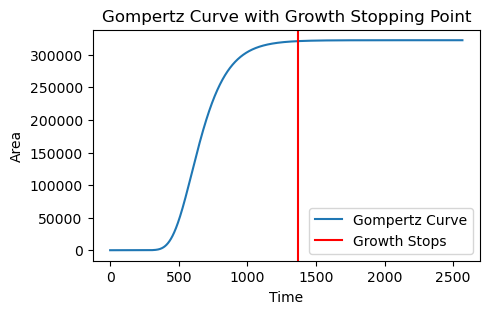

The colony stops growing around time: 1366
57


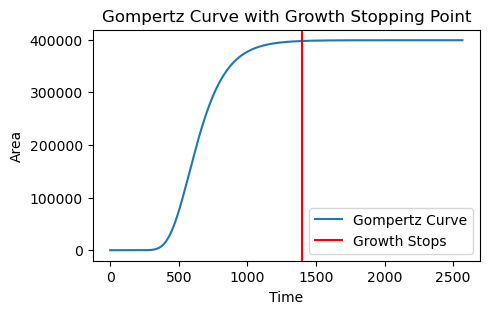

The colony stops growing around time: 1401
58


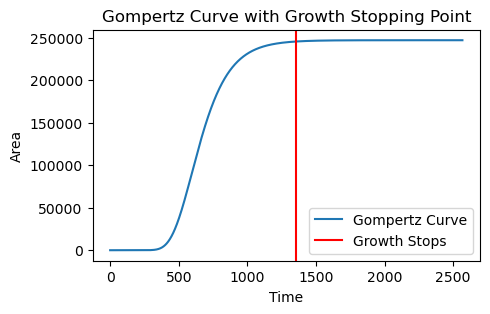

The colony stops growing around time: 1357
59


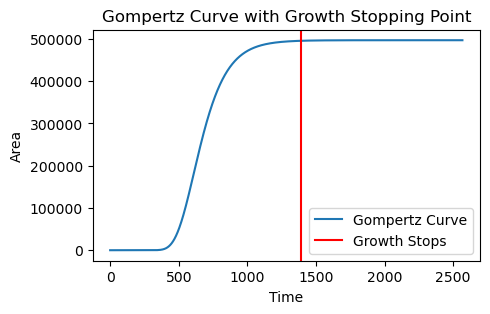

The colony stops growing around time: 1394
60


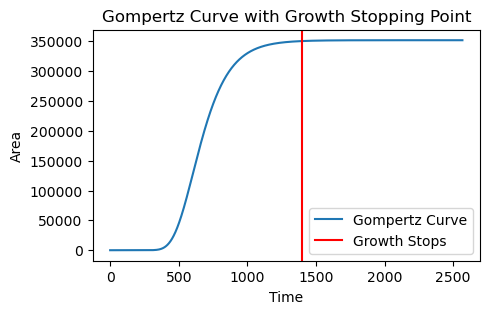

The colony stops growing around time: 1395
61


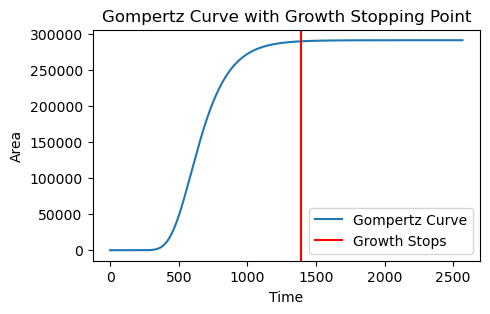

The colony stops growing around time: 1389
62


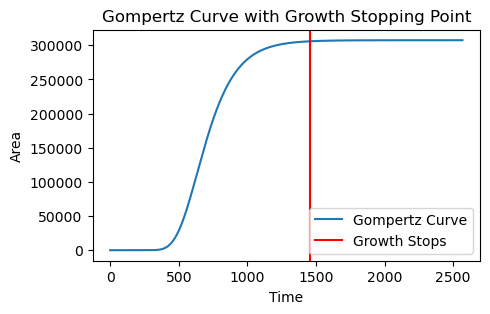

The colony stops growing around time: 1456
63


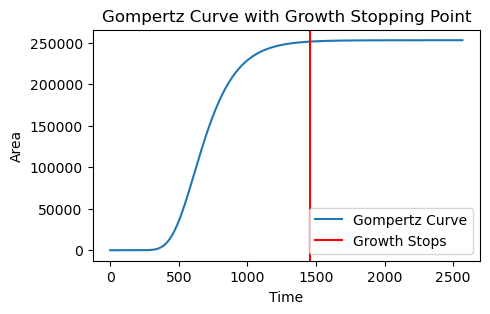

The colony stops growing around time: 1456
64


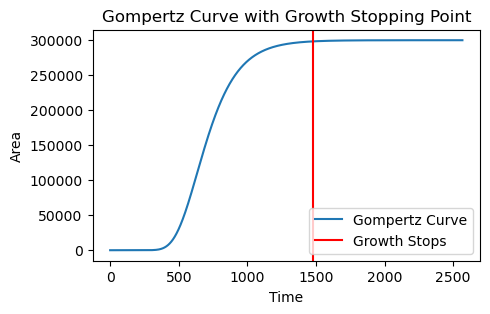

The colony stops growing around time: 1481
65


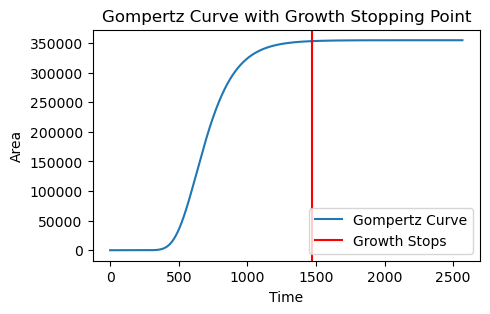

The colony stops growing around time: 1468
66


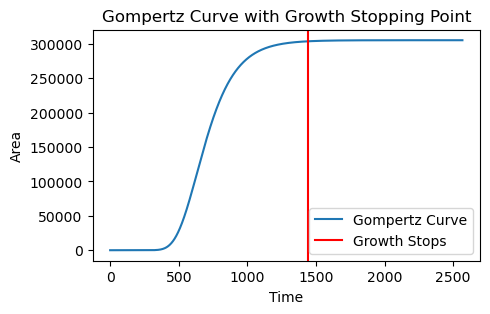

The colony stops growing around time: 1444
67


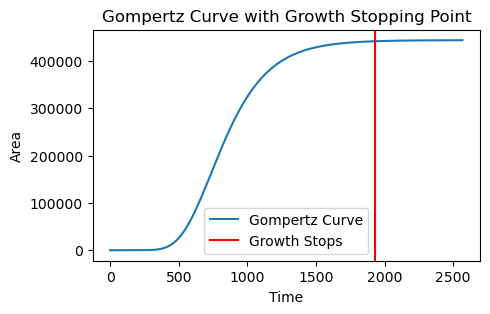

The colony stops growing around time: 1932
68


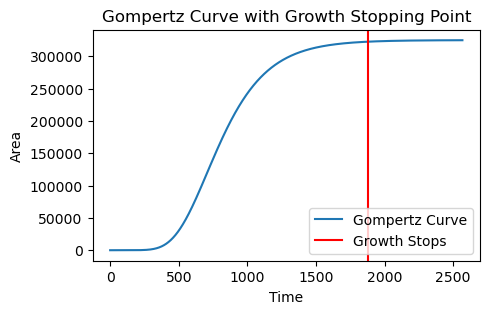

The colony stops growing around time: 1879
69


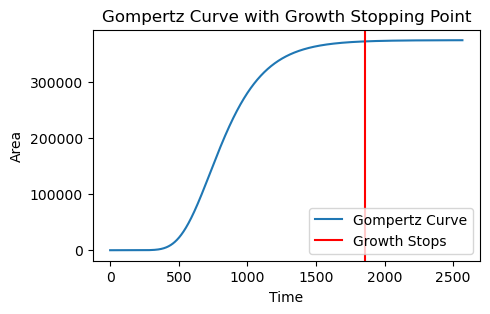

The colony stops growing around time: 1855
70


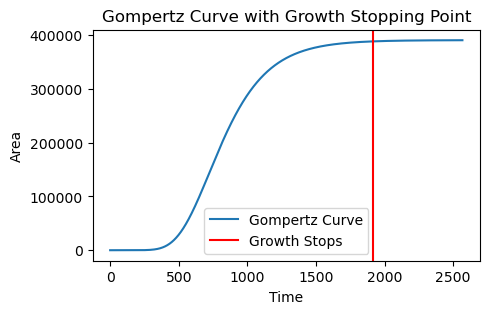

The colony stops growing around time: 1912
71


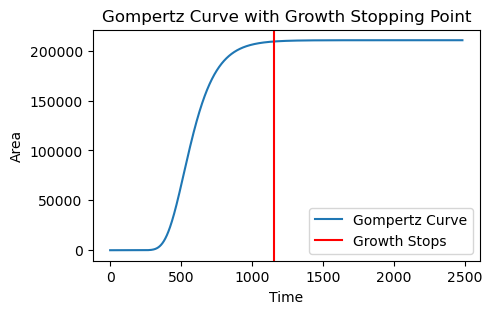

The colony stops growing around time: 1159
72


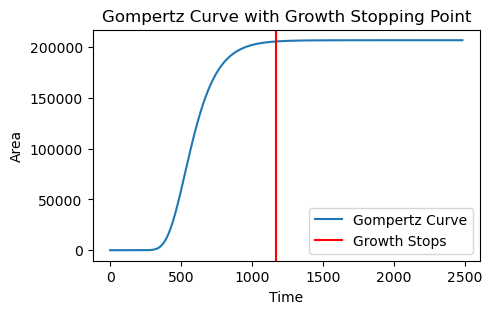

The colony stops growing around time: 1167
73


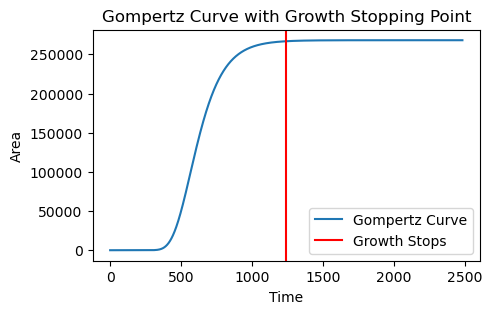

The colony stops growing around time: 1244
74


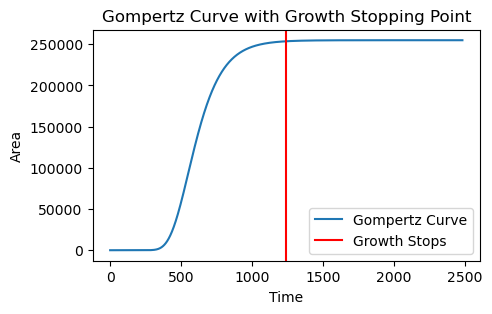

The colony stops growing around time: 1239
75


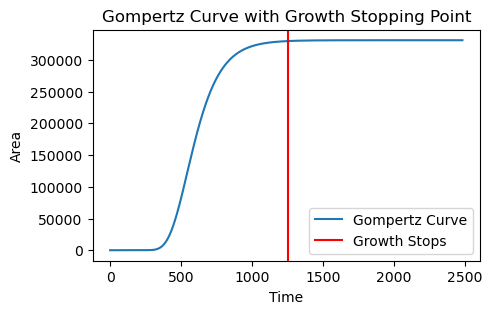

The colony stops growing around time: 1258
76


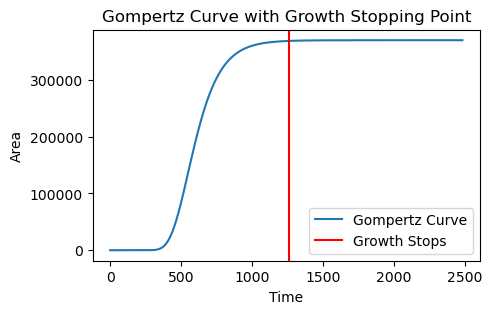

The colony stops growing around time: 1260
77


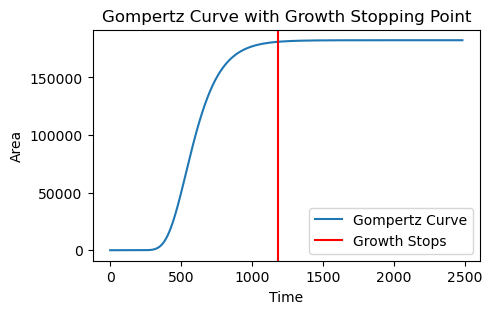

The colony stops growing around time: 1187
78


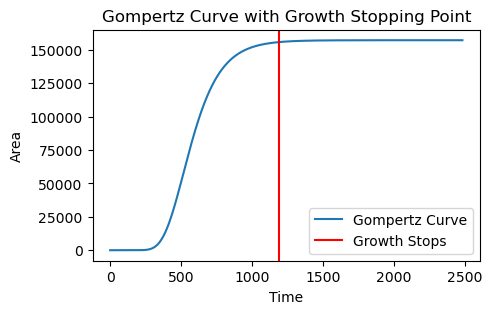

The colony stops growing around time: 1188
79


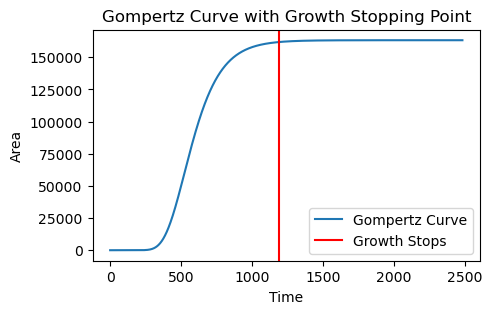

The colony stops growing around time: 1192
80


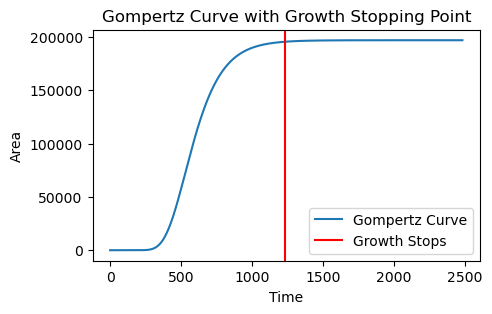

The colony stops growing around time: 1233
81


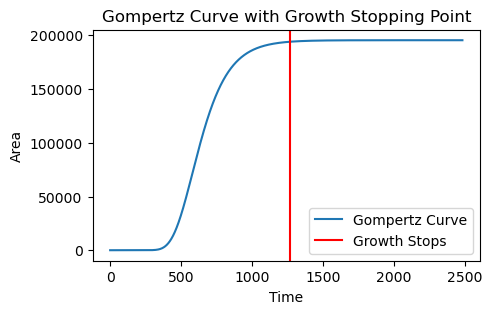

The colony stops growing around time: 1270
82


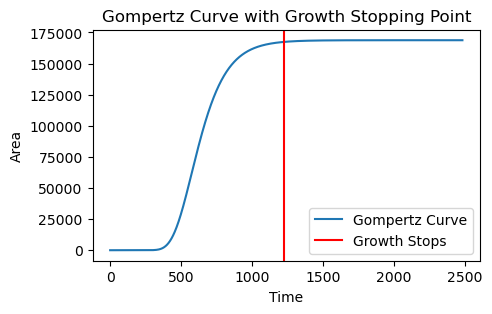

The colony stops growing around time: 1227
83


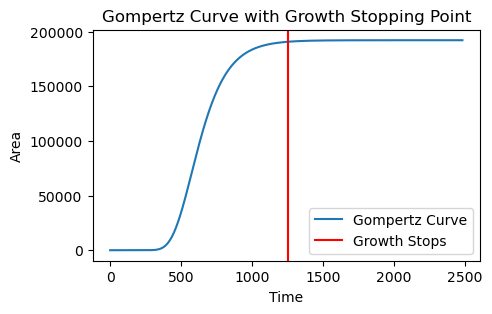

The colony stops growing around time: 1256
84


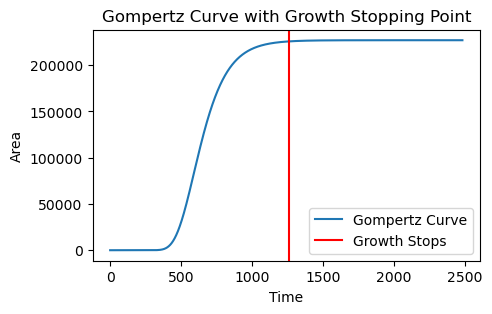

The colony stops growing around time: 1259
85


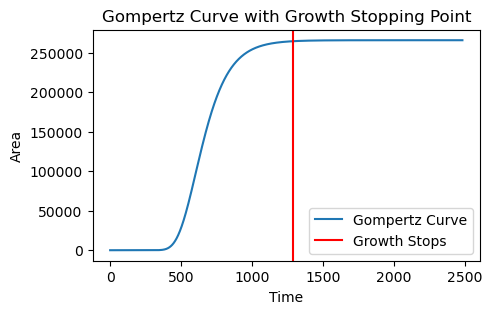

The colony stops growing around time: 1287
86


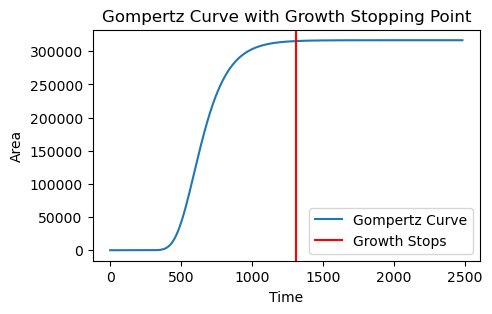

The colony stops growing around time: 1308
87


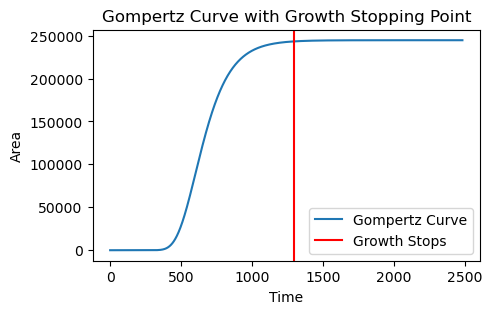

The colony stops growing around time: 1300
88


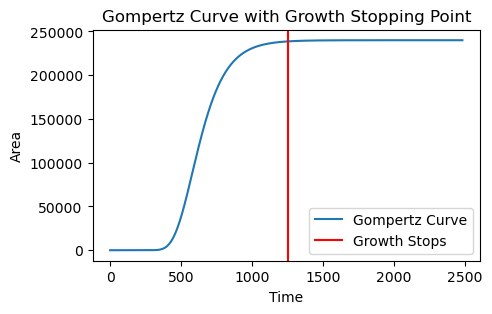

The colony stops growing around time: 1257
89


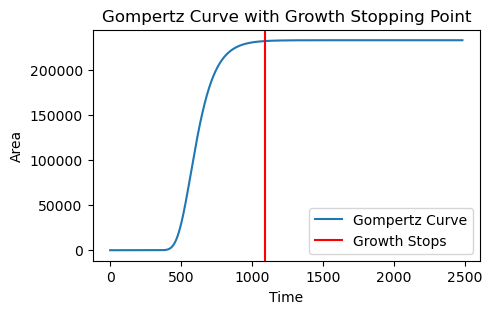

The colony stops growing around time: 1091
90


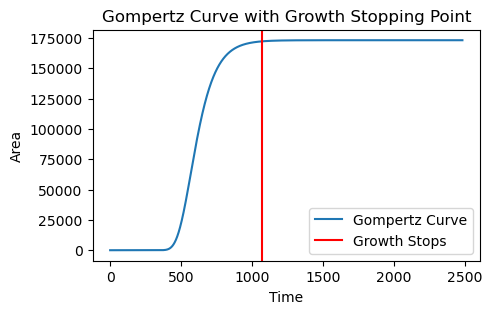

The colony stops growing around time: 1068
91


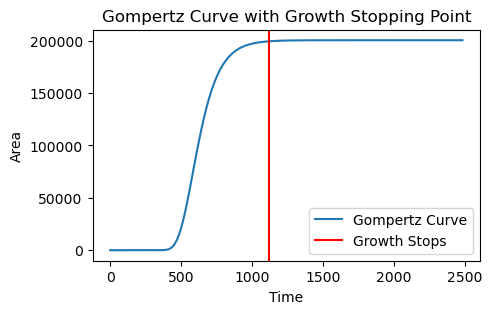

The colony stops growing around time: 1121
92


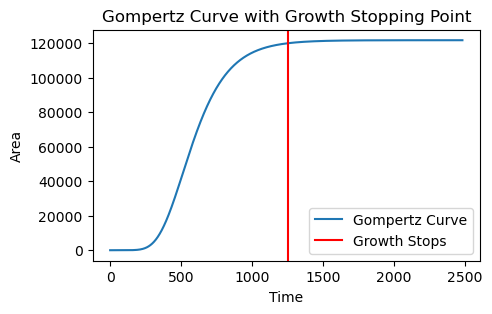

The colony stops growing around time: 1253
93


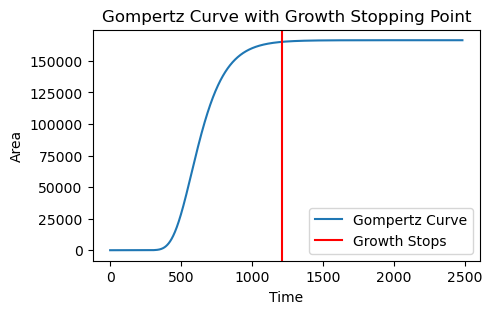

The colony stops growing around time: 1210
94


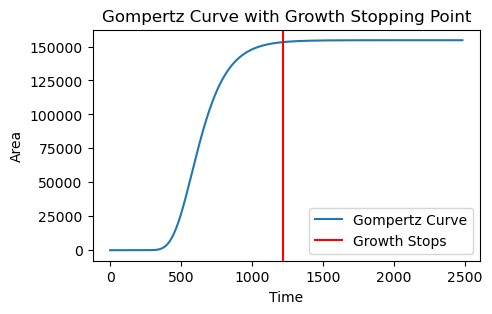

The colony stops growing around time: 1221
95


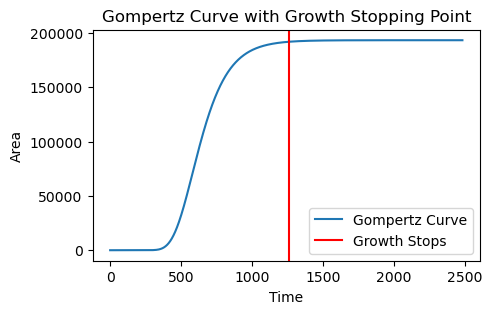

The colony stops growing around time: 1265
96


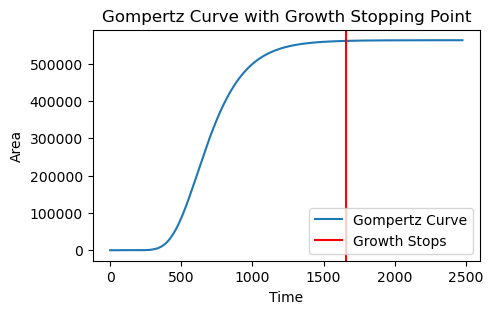

The colony stops growing around time: 1657
97


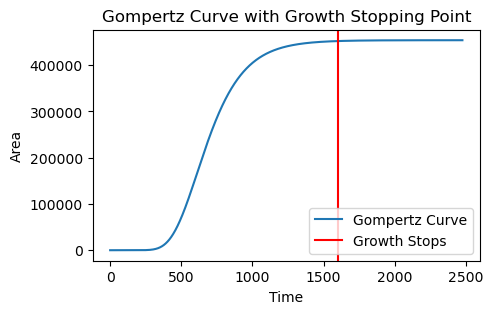

The colony stops growing around time: 1603
98


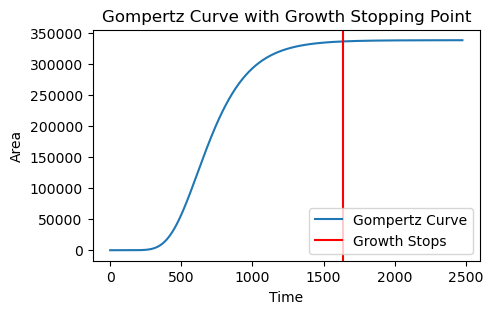

The colony stops growing around time: 1634
99


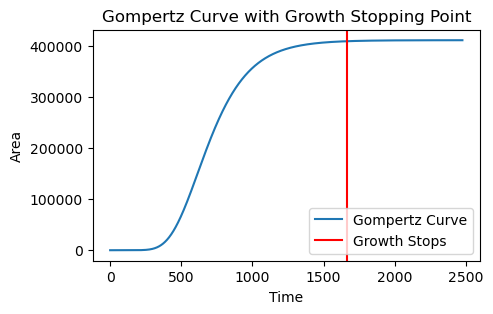

The colony stops growing around time: 1666
100


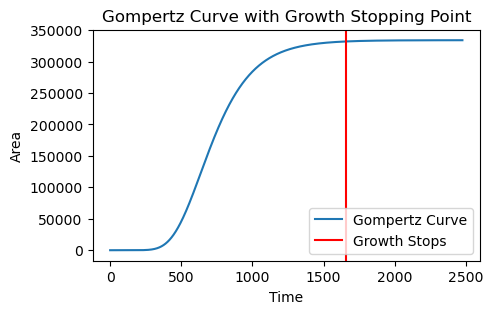

The colony stops growing around time: 1657
101


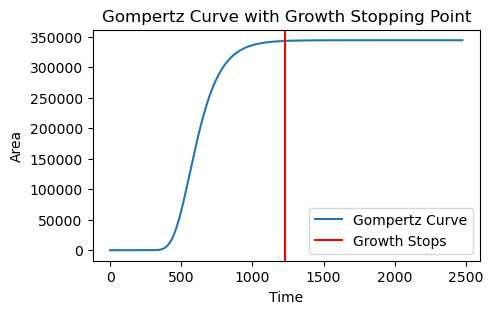

The colony stops growing around time: 1228
102


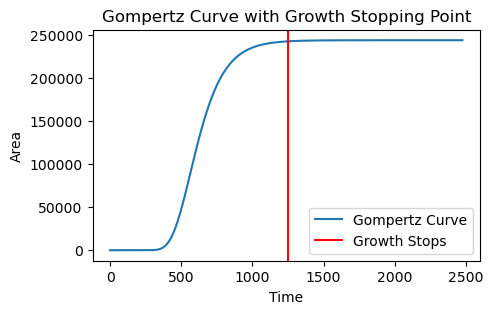

The colony stops growing around time: 1248
103


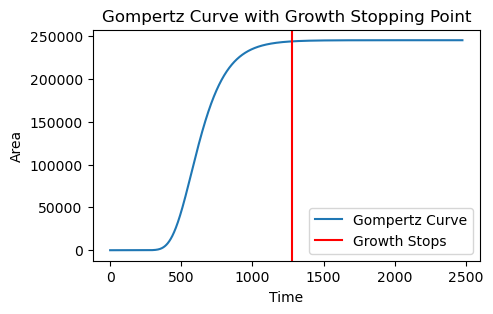

The colony stops growing around time: 1276
104


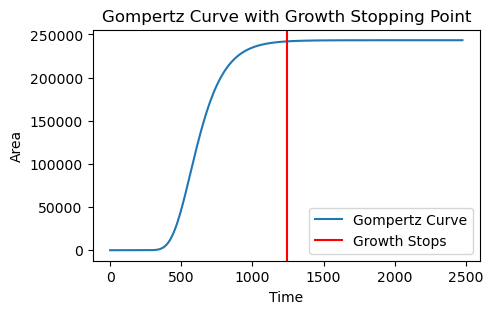

The colony stops growing around time: 1246
105


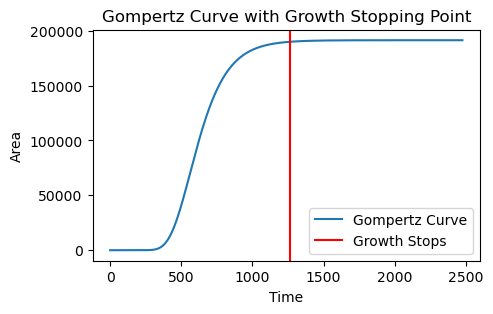

The colony stops growing around time: 1262
106


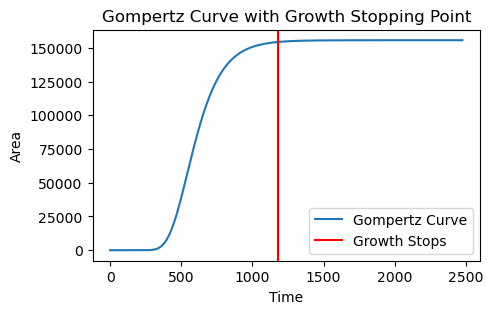

The colony stops growing around time: 1176
107


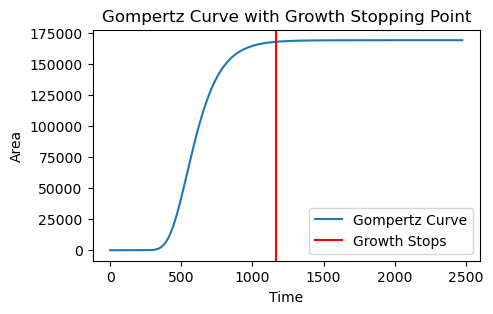

The colony stops growing around time: 1164
108


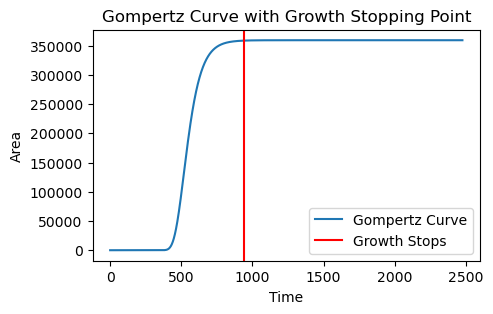

The colony stops growing around time: 941
109


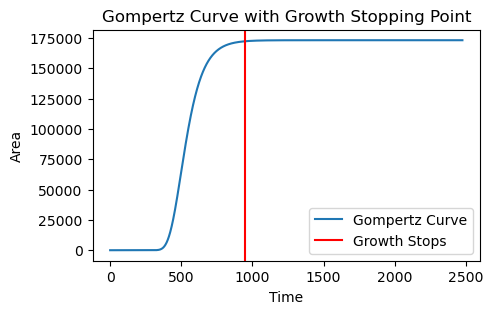

The colony stops growing around time: 949
110


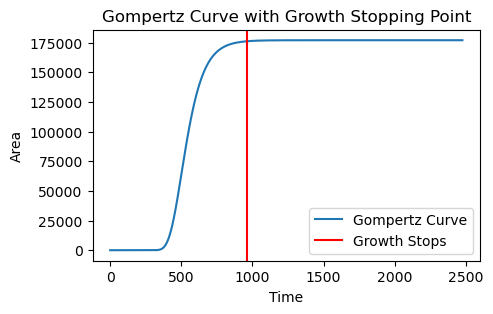

The colony stops growing around time: 962
111


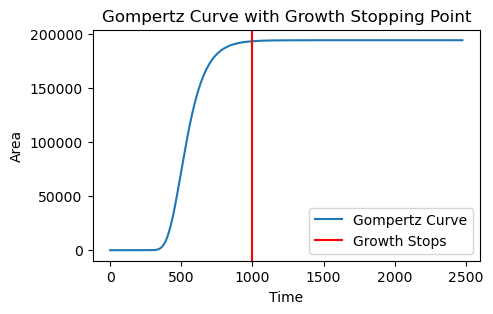

The colony stops growing around time: 999
112


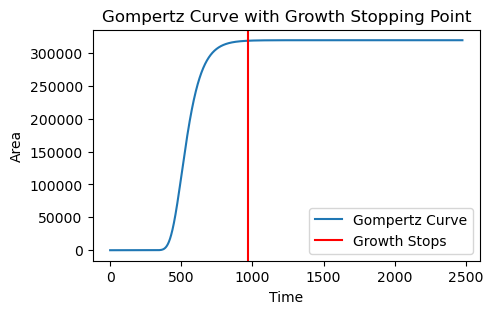

The colony stops growing around time: 969
113


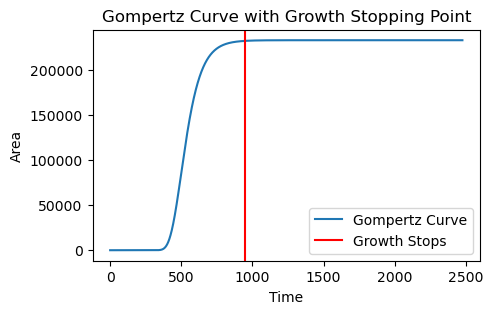

The colony stops growing around time: 944
114


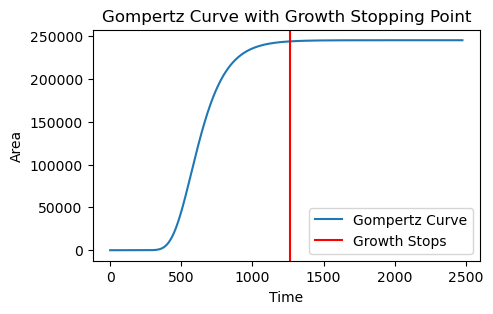

The colony stops growing around time: 1265
115


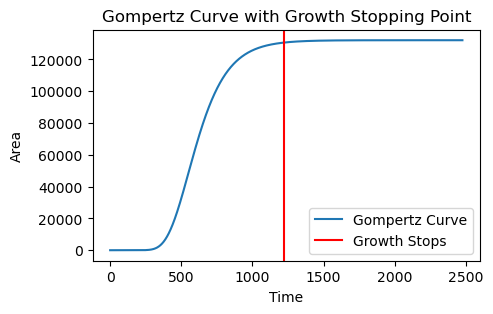

The colony stops growing around time: 1219
116


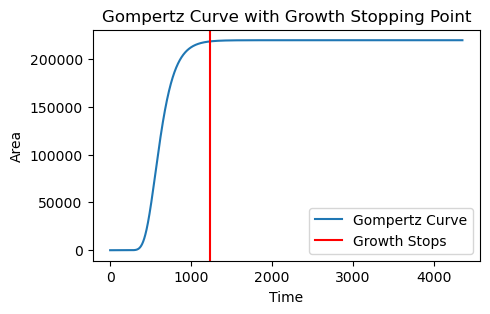

The colony stops growing around time: 1228
117


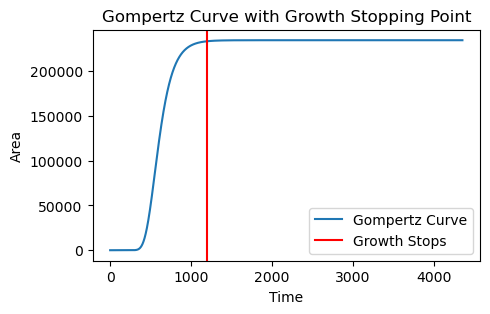

The colony stops growing around time: 1191
118


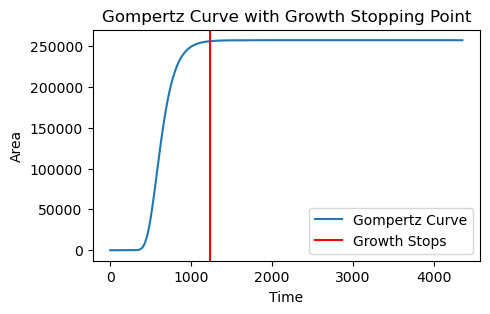

The colony stops growing around time: 1230
119


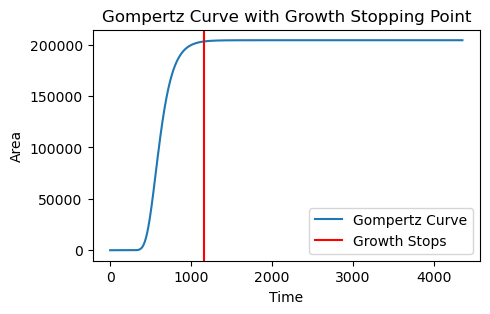

The colony stops growing around time: 1163
120


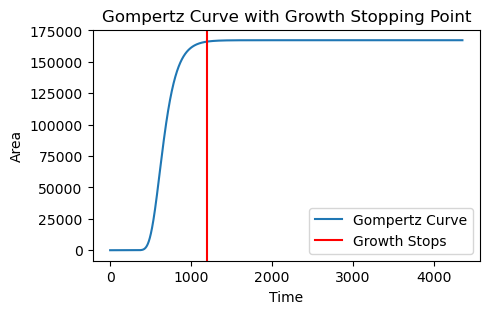

The colony stops growing around time: 1191
121


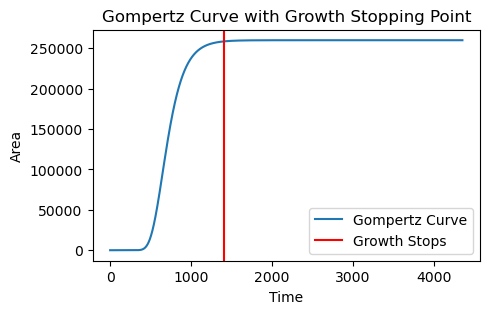

The colony stops growing around time: 1404
122


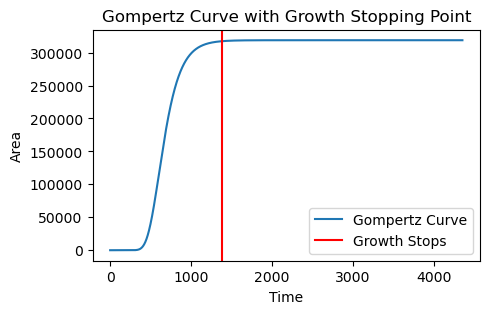

The colony stops growing around time: 1385
123


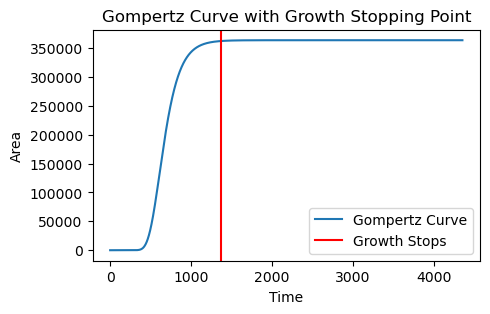

The colony stops growing around time: 1373
124


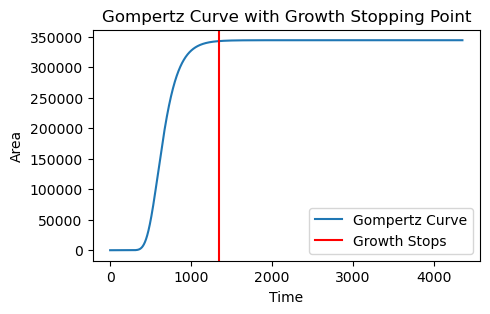

The colony stops growing around time: 1350
125


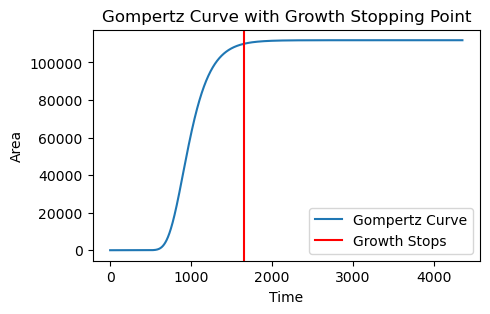

The colony stops growing around time: 1657
126


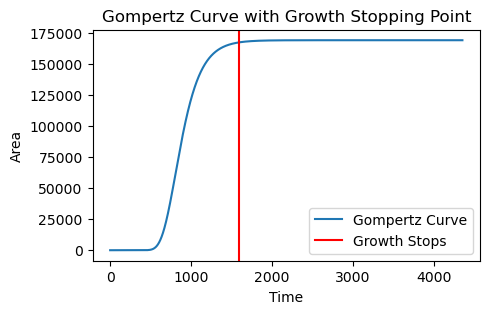

The colony stops growing around time: 1595
127


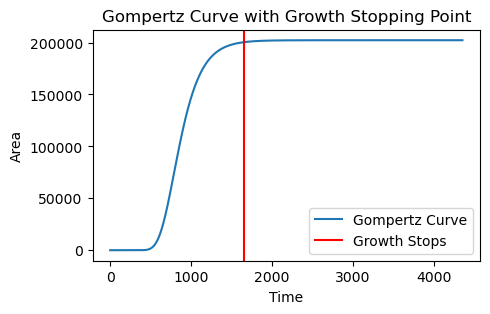

The colony stops growing around time: 1655
128


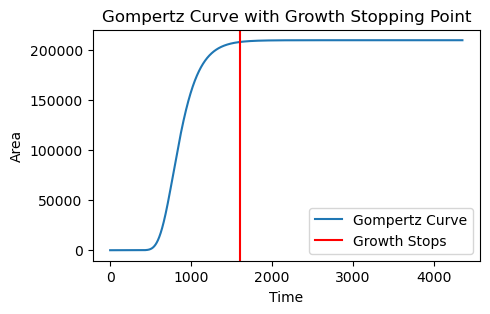

The colony stops growing around time: 1606
129


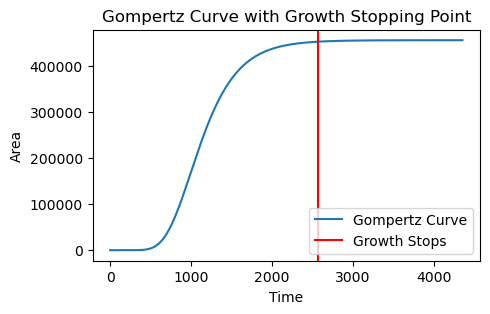

The colony stops growing around time: 2568
130


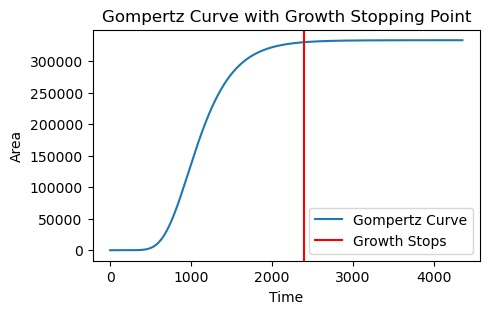

The colony stops growing around time: 2399
131


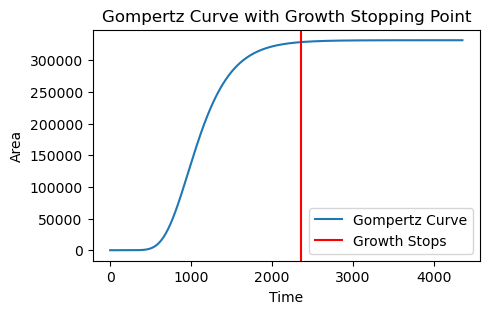

The colony stops growing around time: 2358
132


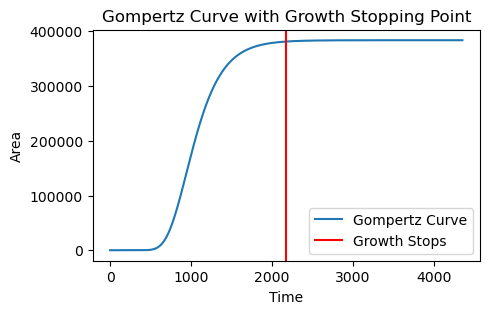

The colony stops growing around time: 2172
133


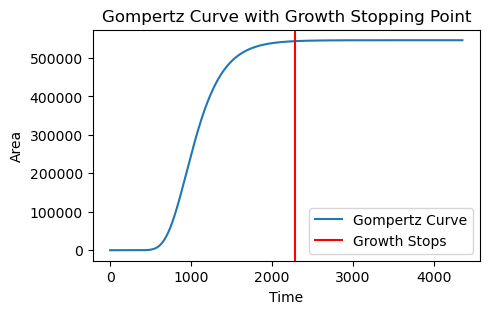

The colony stops growing around time: 2278
134


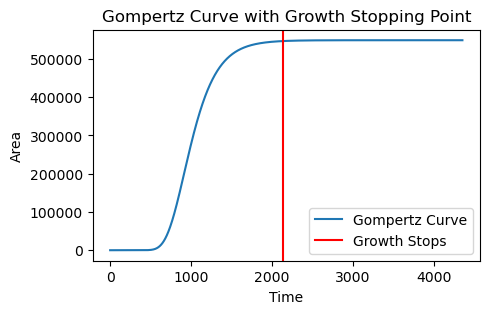

The colony stops growing around time: 2134
135


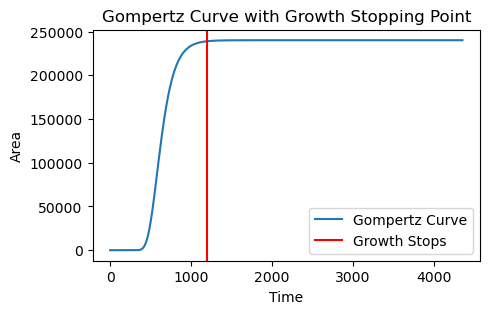

The colony stops growing around time: 1197
136


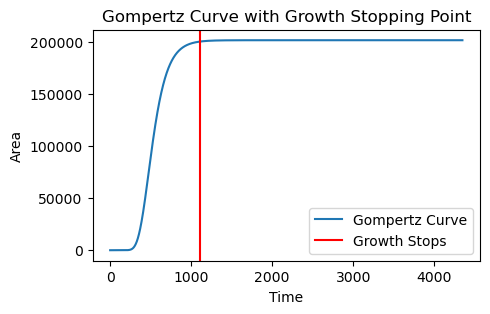

The colony stops growing around time: 1113
137


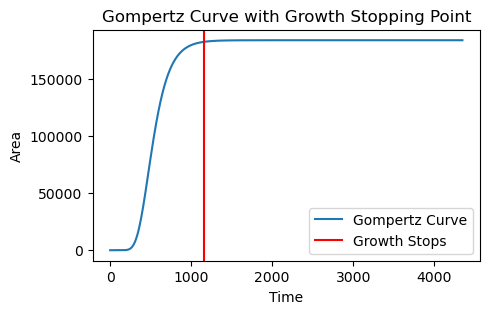

The colony stops growing around time: 1158
138


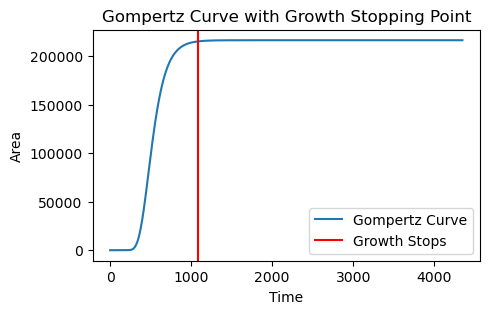

The colony stops growing around time: 1087
139


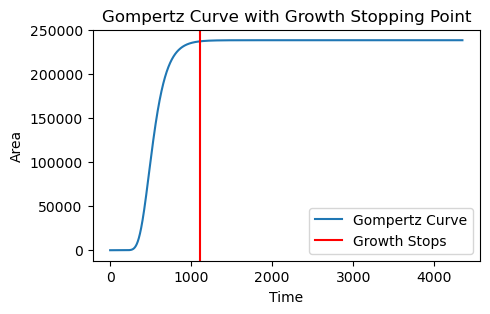

The colony stops growing around time: 1115
140


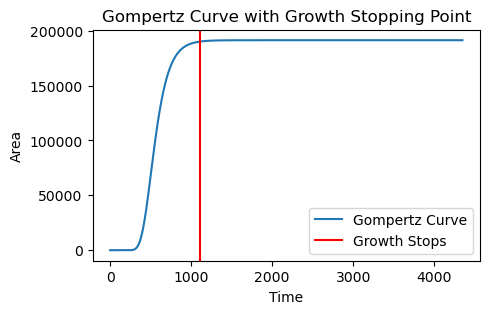

The colony stops growing around time: 1111
141


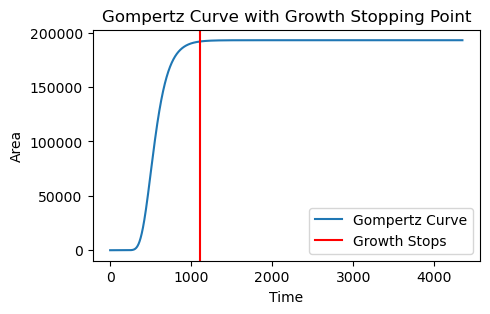

The colony stops growing around time: 1107
142


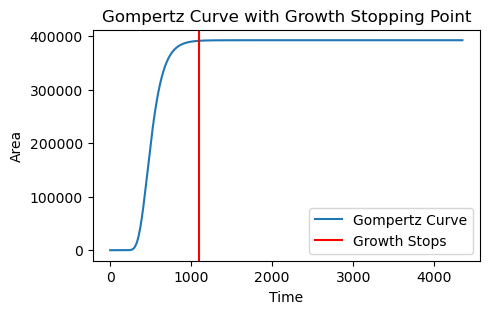

The colony stops growing around time: 1097
143


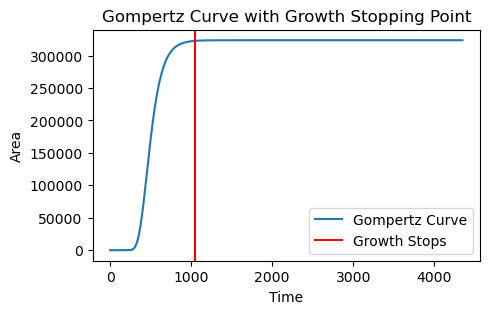

The colony stops growing around time: 1045
144


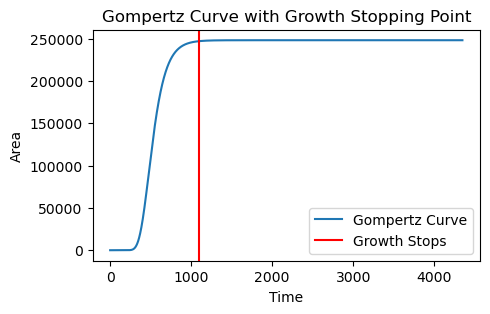

The colony stops growing around time: 1095
145


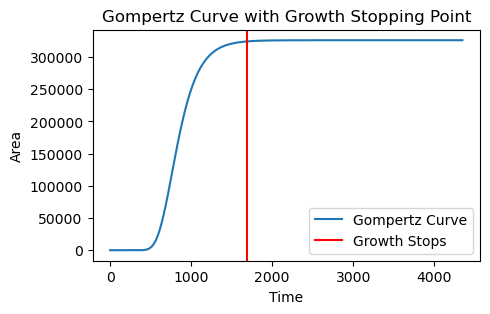

The colony stops growing around time: 1695
146


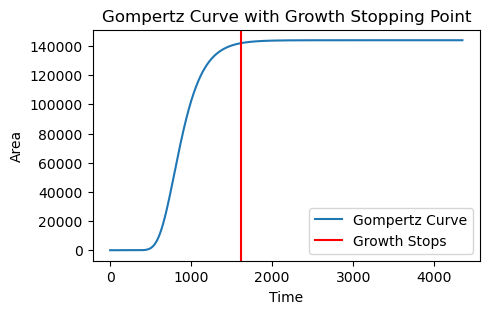

The colony stops growing around time: 1621
147


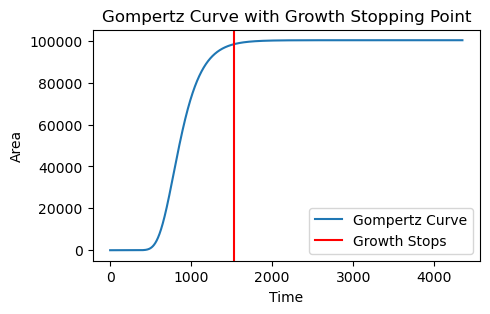

The colony stops growing around time: 1529
148


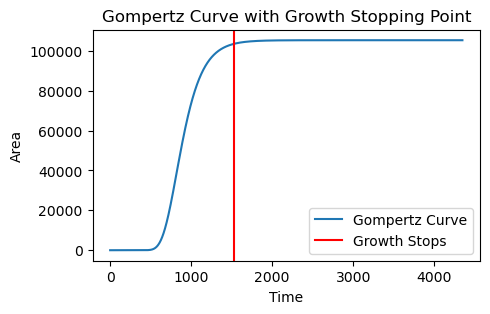

The colony stops growing around time: 1534
149


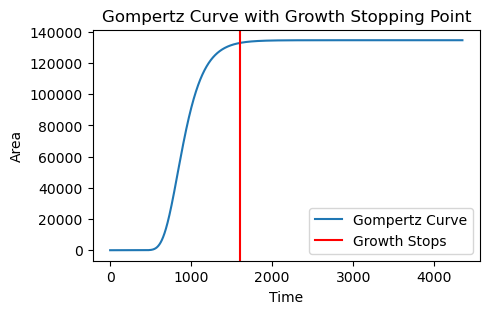

The colony stops growing around time: 1598
150


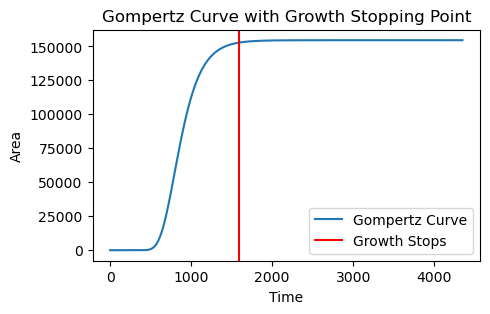

The colony stops growing around time: 1588
151


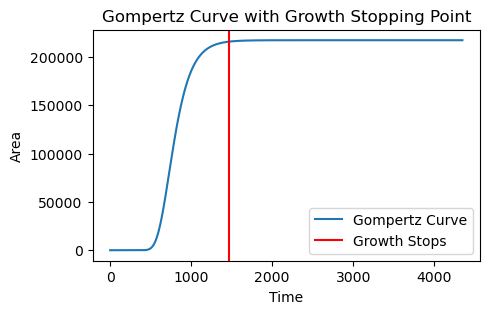

The colony stops growing around time: 1465
152


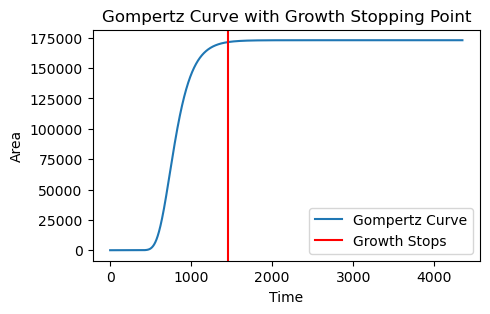

The colony stops growing around time: 1456
153


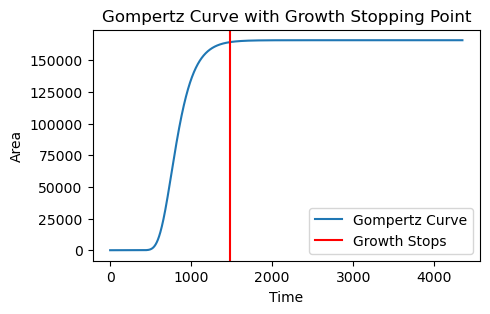

The colony stops growing around time: 1475
154


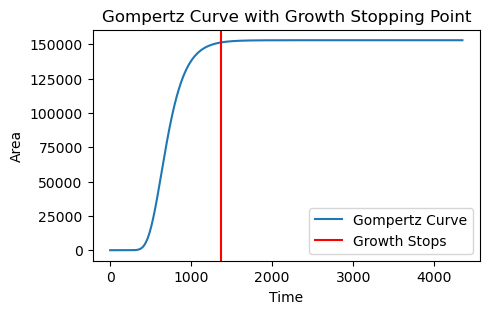

The colony stops growing around time: 1368
155


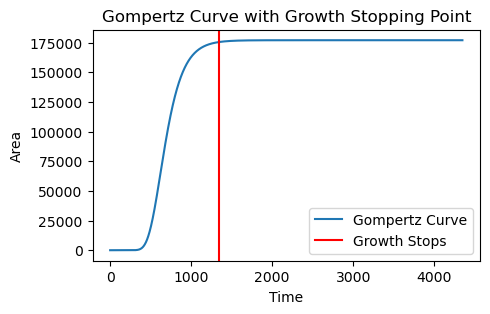

The colony stops growing around time: 1345
156


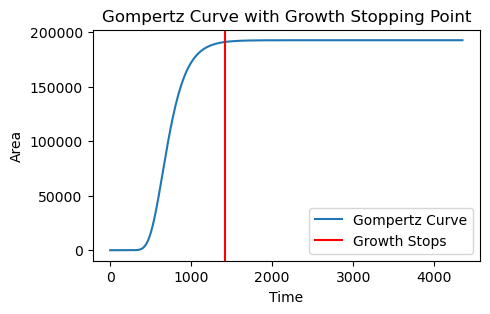

The colony stops growing around time: 1417
157


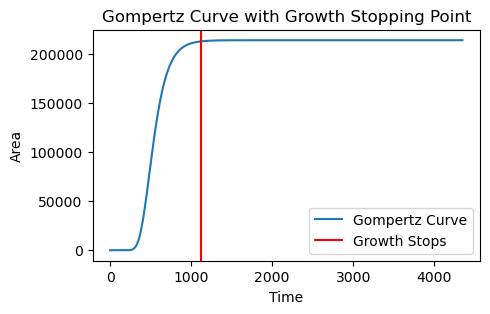

The colony stops growing around time: 1116
158


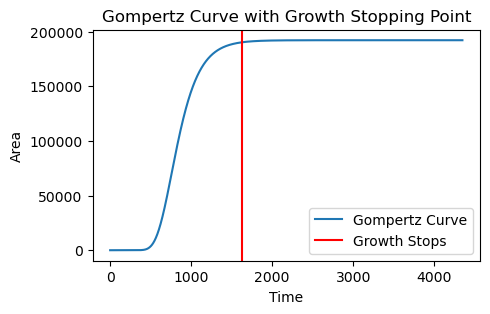

The colony stops growing around time: 1628
159


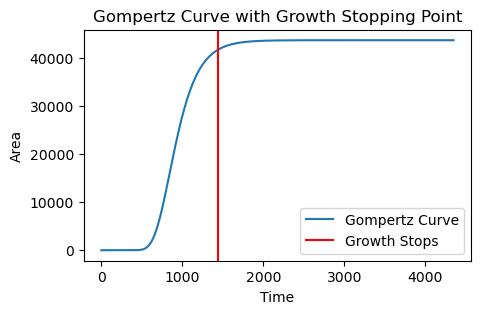

The colony stops growing around time: 1440


In [17]:
for i in df.index.values:
    print(i)
    params = [df.loc[i,'A_gomp_um'],df.loc[i,'mu_gomp_um'],df.loc[i,'l_gomp_um']]
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60 ## time in minutes
    tf = int(incub_time_n + df.loc[i, 'exp length']*10) # end of the experiment
    
    time = np.arange(0, tf)
    gomp = gompertz(time, *params)  # Gompertz curve based on fitted parameters
    
    ggr = savgol_filter(gomp, 21, 1, deriv=1) # derivative of the Gompertz curve (growth rate)
    max_growth_idx = np.argmax(ggr)
    
    # threshold for when the growth rate is considered to have stopped
    threshold = 10 # this is about 10 um  
    
    # find where growth rate drops below the threshold after the period of max growth
    stopping_idx = np.where((ggr[max_growth_idx:] < threshold))[0]
    
    # Add max_growth_idx to the stopping_idx to get the correct position in the original array
    if stopping_idx.size > 0:
        stopping_idx = stopping_idx[0] + max_growth_idx  # First point after max growth where ggr < threshold
    else:
        stopping_idx = len(time) - 1  # If no point is found, set it to the end of the time range
    
    stopping_time = time[stopping_idx]
    df.at[i, 'gomp_growth_stops_10'] = stopping_time
    plt.figure(figsize=(5,3))

    plt.plot(time, gomp, label='Gompertz Curve')
    
    # Mark the stopping point
    #plt.scatter(stopping_time, gomp[stopping_idx], color='red', zorder=5, label='Growth Stops')
    plt.axvline(stopping_time, color='red', label='Growth Stops')
    # Label and title
    plt.xlabel('Time')
    plt.ylabel('Area')
    plt.title('Gompertz Curve with Growth Stopping Point')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Output the result
    print(f"The colony stops growing around time: {stopping_time}")


In [18]:
#df.to_excel('../data_processed.xlsx', index=False)

In [34]:
df = pd.read_excel('../data_processed.xlsx')

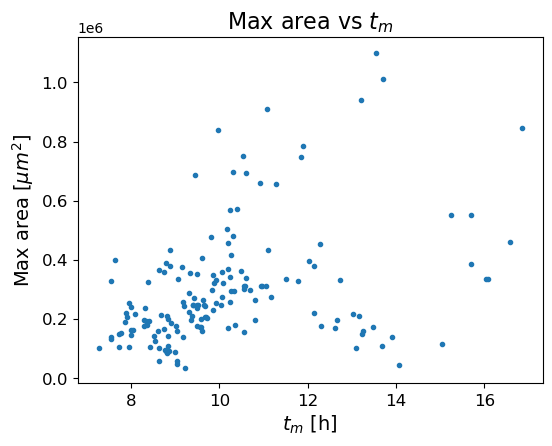

In [83]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['area_max_um'], '.')
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)
# plt.ylim([0,50])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('Max area vs $t_m$', fontsize=16)
#plt.savefig('MaxA_tm.png', dpi=300)
plt.show()


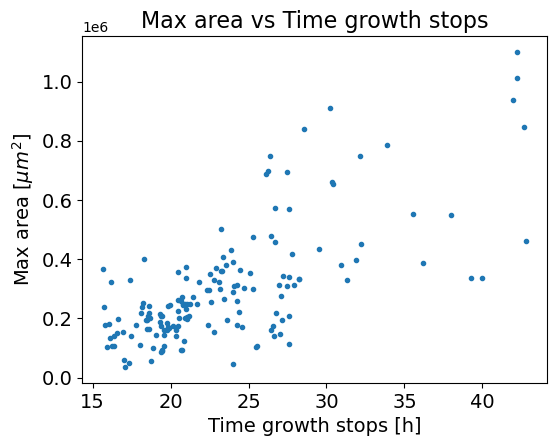

In [36]:
plt.figure(figsize=(6,4.5))

plt.plot(df['gomp_growth_stops_10'] / 60, df['area_max_um'], '.')
plt.xlabel('Time growth stops [h]', fontsize=14)
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Max area vs Time growth stops', fontsize=16)
#plt.savefig('MaxA_tstop.png', dpi=300)
plt.show()

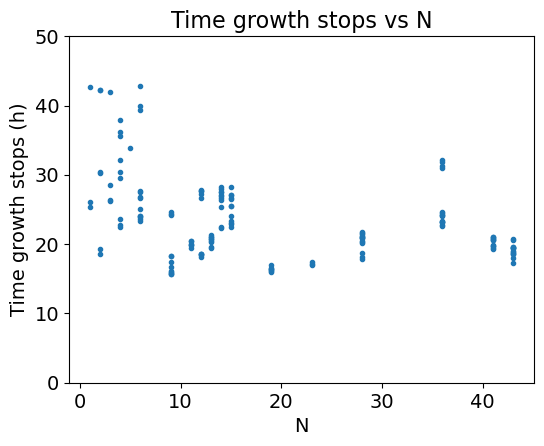

In [38]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['gomp_growth_stops_10'] / 60, '.')
plt.ylabel('Time growth stops (h)', fontsize=14)
plt.ylim([0, 50])
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Time growth stops vs N', fontsize=16)
#plt.savefig('tstop_N.png', dpi=300)
plt.show()

#### $t_m$

In [21]:
for i in df.index.values:
    params = [df.loc[i,'A_gomp_um'],df.loc[i,'mu_gomp_um'],df.loc[i,'l_gomp_um']]
    tm = tm_gomp(*params)
    df.loc[i,'tm_um'] = tm

In [22]:
#df.to_excel('../data_processed.xlsx', index=False)

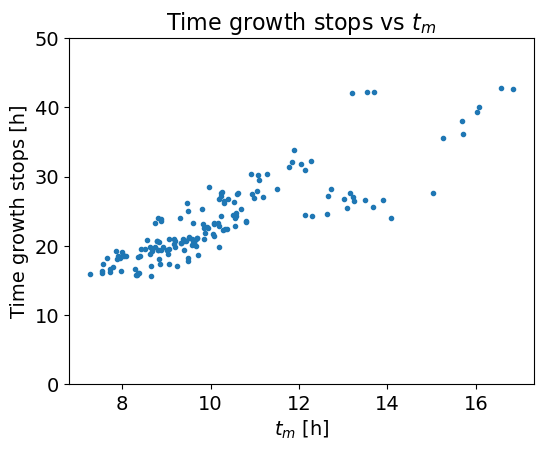

In [40]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['gomp_growth_stops_10'] / 60, '.')
plt.ylabel('Time growth stops [h]', fontsize=14)
plt.ylim([0, 50])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Time growth stops vs $t_m$', fontsize=16)
#plt.savefig('tstop_tm.png', dpi=300)
plt.show()

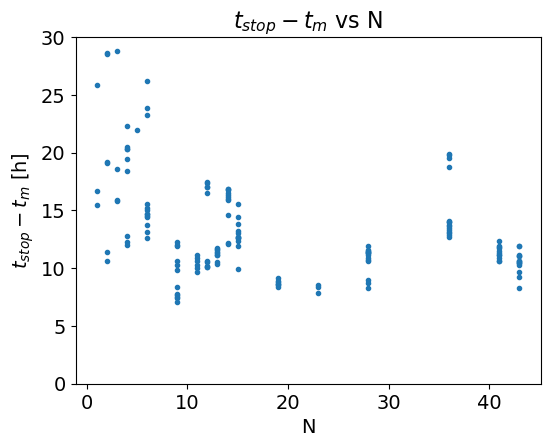

In [47]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['gomp_growth_stops_10'] / 60 - df['tm_um'] / 60, '.')
plt.xlabel('N', fontsize=14)
plt.ylabel('$t_{stop} - t_m$ [h]', fontsize=14)
plt.ylim([0, 30])

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_{stop} - t_m$ vs N', fontsize=16)
#plt.savefig('tstop-tm_N.png', dpi=300)
plt.show()


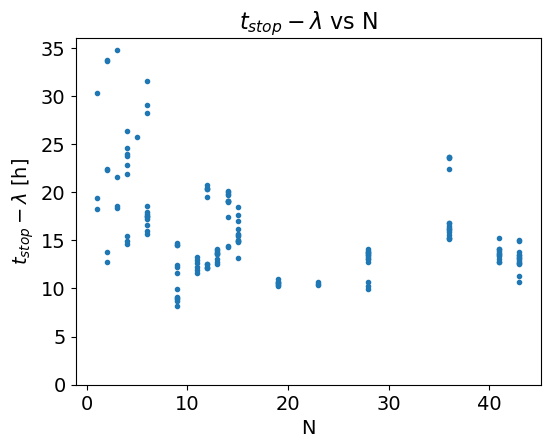

In [51]:
## is there a constant value for tstop - lambda?
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['gomp_growth_stops_10'] / 60 - df['l_gomp_um'] / 60, '.')
plt.xlabel('N', fontsize=14)
plt.ylabel('$t_{stop} - \\lambda$ [h]', fontsize=14)
plt.ylim([0, 36])

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_{stop} - \\lambda$ vs N', fontsize=16)
#plt.savefig('tstop-lambda_N.png', dpi=300)
plt.show()

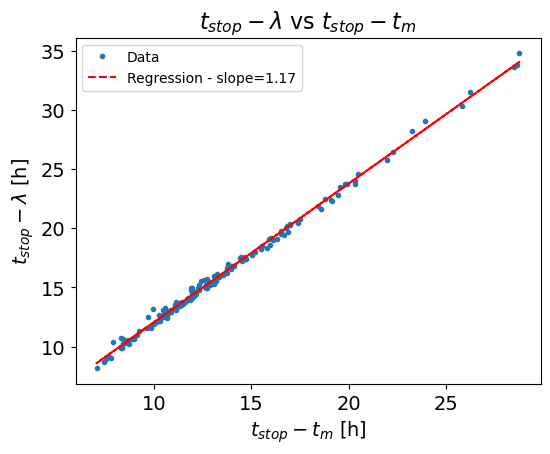

In [68]:
plt.figure(figsize=(6,4.5))

# Data for the plot
x = df['gomp_growth_stops_10'] / 60 - df['tm_um'] / 60
y = df['gomp_growth_stops_10'] / 60 - df['l_gomp_um'] / 60

# Perform the linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept  # Calculate the regression line

# Plot the data points
plt.plot(x, y, '.', label='Data')

# Plot the regression line
plt.plot(x, regression_line, '--', color='red', label=f'Regression - slope={slope:.2f}')

# Labels and title
plt.xlabel('$t_{stop} - t_m$ [h]', fontsize=14)
plt.ylabel('$t_{stop} - \\lambda$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

# Title and legend
plt.title('$t_{stop} - \\lambda$ vs $t_{stop} - t_m$', fontsize=16)
plt.legend()
#plt.savefig('tstop-lambda_tstop-tm.png', dpi=300)
# Show plot
plt.show()


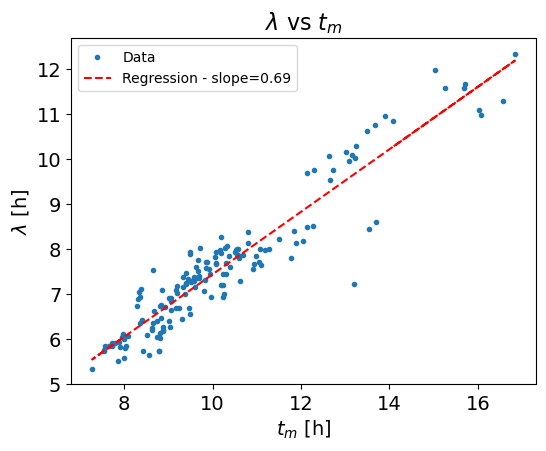

In [69]:
plt.figure(figsize=(6,4.5))

# Scatter plot
plt.plot(df['tm_um'] / 60, df['l_gomp_um'] / 60, '.', label='Data')

# Linear regression (fit a line)
slope, intercept = np.polyfit(df['tm_um'] / 60, df['l_gomp_um'] / 60, 1)
regression_line = slope * (df['tm_um'] / 60) + intercept

# Plot the regression line
plt.plot(df['tm_um'] / 60, regression_line, '--', color='red', label=f'Regression - slope={slope:.2f}')

plt.xlabel('$t_m$ [h]', fontsize=14)
plt.ylabel('$\\lambda$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$\\lambda$ vs $t_m$', fontsize=16)

# Add a legend for the regression line
plt.legend()
#plt.savefig('lambda_tm.png', dpi=300)
plt.show()


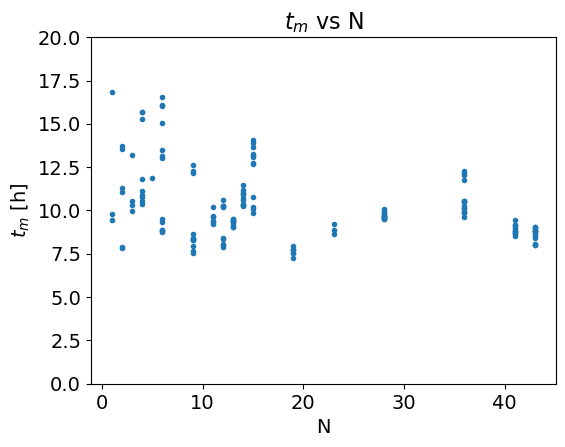

In [73]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['tm_um'] / 60, '.')
plt.ylabel('$t_m$ [h]', fontsize=14)
plt.ylim([0, 20])
plt.xlabel('N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_m$ vs N', fontsize=16)
#plt.savefig('tm_N.png', dpi=300)
plt.show()

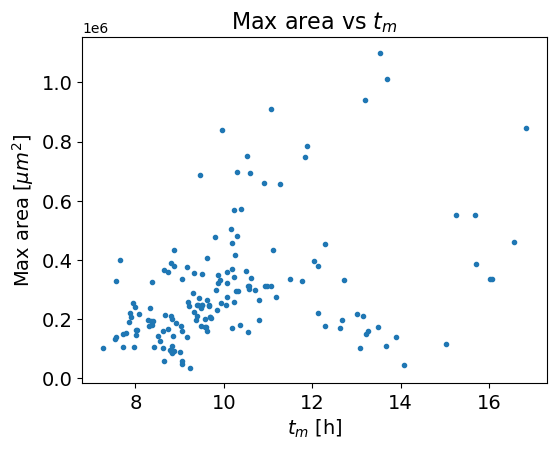

In [77]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['area_max_um'], '.')
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)
# plt.ylim([0,50])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Max area vs $t_m$', fontsize=16)
#plt.savefig('MaxArea_tm.png', dpi=300)
plt.show()


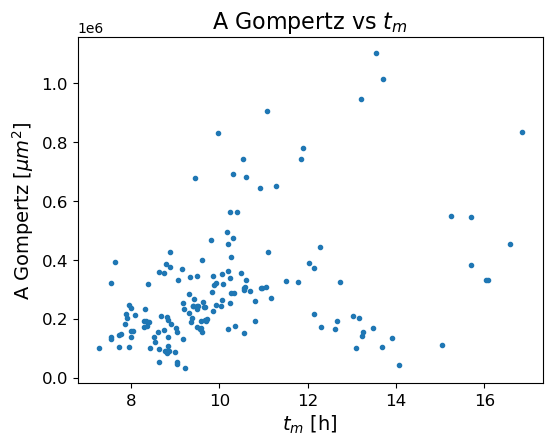

In [86]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['A_gomp_um'], '.')
plt.ylabel('A Gompertz [$\\mu m^2$]', fontsize=14)
# plt.xlim([0,18])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('A Gompertz vs $t_m$', fontsize=16)
#plt.savefig('AGomp_tm.png', dpi=300)
plt.show()


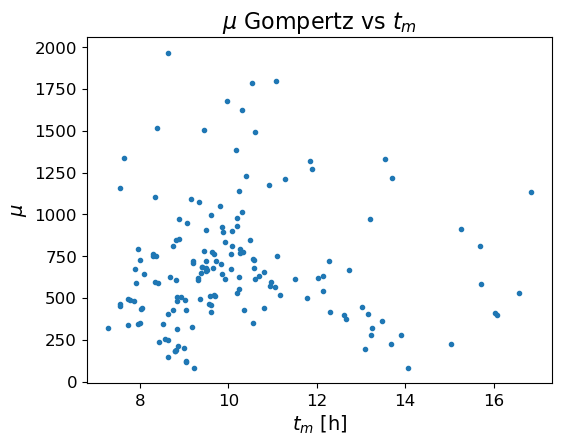

In [90]:
plt.figure(figsize=(6,4.5))

# plt.yscale('log')  # Commented out as requested
plt.plot(df['tm_um'] / 60, df['mu_gomp_um'], '.')
plt.ylabel('$\\mu$', fontsize=14)
# plt.ylim([0,20])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('$\\mu$ Gompertz vs $t_m$', fontsize=16)
#plt.savefig('muGomp_tm.png', dpi=300)
plt.show()

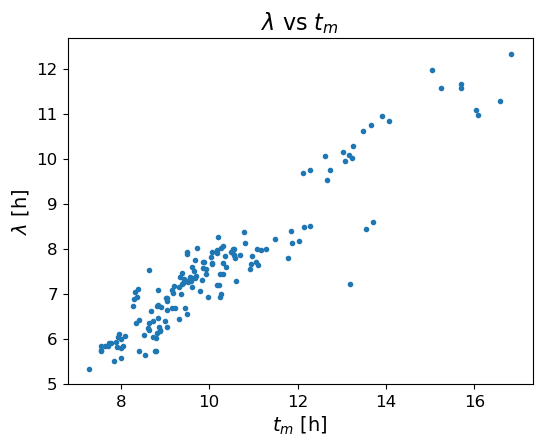

In [93]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['l_gomp_um'] / 60, '.')
plt.ylabel('$\\lambda$ [h]', fontsize=14)
# plt.ylim([0,20])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('$\\lambda$ vs $t_m$', fontsize=16)
#plt.savefig('lGomp_tm.png', dpi=300)
plt.show()


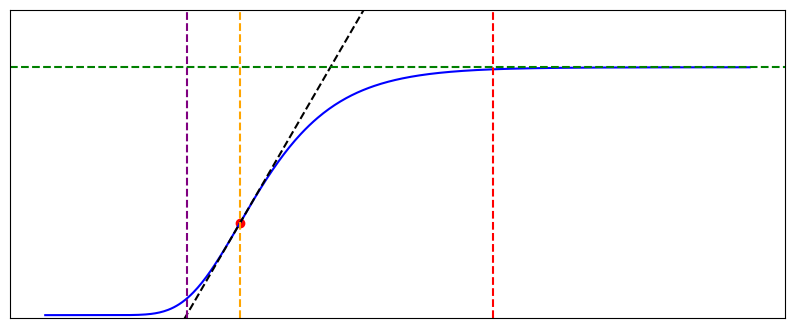

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Gompertz function definition
def gompertz(t, A, mu, l):
    return A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))

# Derivative of the Gompertz function (numerical derivative)
def gompertz_derivative(t, A, mu, l):
    epsilon = 1e-5  # Small value for numerical differentiation
    return (gompertz(t + epsilon, A, mu, l) - gompertz(t - epsilon, A, mu, l)) / (2 * epsilon)

# Gompertz parameters (use the provided values)
# pAAA 11_30 pos 15 Tweez
gomp_params = {"A": 86590.16997388891, "mu_m": 242.29351344003047, "lambda": 350.9260575006792}
A = gomp_params['A']
mu_m = gomp_params['mu_m']
lambda_ = gomp_params['lambda']

# Time range for plotting
t = np.linspace(0, 1750, 500)

# Calculate Gompertz curve
gompertz_values = gompertz(t, A, mu_m, lambda_)

# Calculate the derivative of the Gompertz curve numerically
gompertz_derivatives = gompertz_derivative(t, A, mu_m, lambda_)

# Find the maximum derivative and its index (this corresponds to the inflection point)
max_slope_index = np.argmax(gompertz_derivatives)
max_slope = gompertz_derivatives[max_slope_index]
t_max_slope = t[max_slope_index]  # Automatically obtained, not hardcoded
y_max_slope = gompertz(t_max_slope, A, mu_m, lambda_)

# Find the intersection of the tangent line with the x-axis (i.e., y = 0)
lambda_calculated = t_max_slope - y_max_slope / max_slope

# Create the plot
plt.figure(figsize=(10,4))

# Plot the Gompertz curve
plt.plot(t, gompertz_values, label="Gompertz curve", color='blue')

# Plot the point of maximum derivative (inflection point)
plt.scatter(t_max_slope, y_max_slope, color='red', label=f'Max slope (t={t_max_slope:.2f}, y={y_max_slope:.2f})')

# Plot the tangent line at the maximum slope
tangent_line = max_slope * (t - t_max_slope) + y_max_slope
plt.plot(t, tangent_line, color='black', linestyle='--', label=f'Tangent line at max slope = {max_slope:.2f}')

# Plot vertical line at lambda_calculated (intersection with x-axis)
plt.axvline(x=lambda_calculated, color='purple', linestyle='--', label=f'Calculated Lambda = {lambda_calculated:.2f}')

# Plot horizontal line for A (asymptote)
plt.axhline(y=A, color='green', linestyle='--', label=f'Asymptote A = {A:.2f}')

# Plot vertical line where maximum slope occurs (t_max_slope)
plt.axvline(x=t_max_slope, color='orange', linestyle='--', label=f'Max slope time (t = {t_max_slope:.2f})')

# Plot vertical line at t = 1111
plt.axvline(x=1111, color='red', linestyle='--', label='Vertical line at t = 1111')

# Add labels and legend
#plt.xlabel('Time (t)', fontsize=14)
#plt.ylabel('Population/Area', fontsize=14)
#plt.title('Gompertz Model with Inflection Point and Tangent Line', fontsize=16)
#plt.legend()

# Set y-limits for a cleaner view
plt.ylim([-1000, A + 20000])

plt.xticks([])
plt.yticks([])
plt.savefig('Gomp_cartoon.png',dpi=300)
# Show the plot
plt.show()
